# Полносвязные сети. Pytorch.

# 全连接神经网络

# fully connected neural networks


Перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

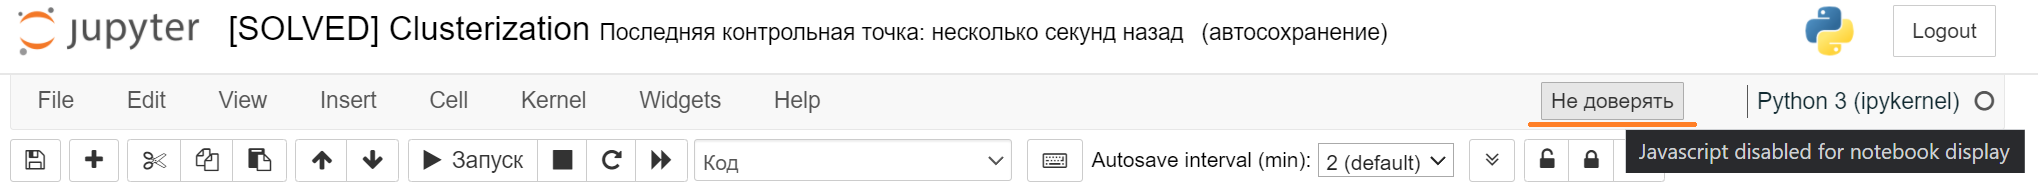

### Implementation of a neural network
# 神经网络的实现

在此任务中，将通过独立实现学习和预测算法的所有组件来训练完全连接的神经网络来识别手写数字。

为了实现该模型，我们将使用 Pytorch 框架。 实现神经网络模型的标准方法是将其分解为单独的块。 使用此库，可以从现成的层块创建两个模型并实现自己的模块。 同时，Pytorch 隐藏了与从输入计算模型输出和计算梯度相关的所有复杂性，这使得该库在使用随机梯度下降（SGD）、LBFGS 等梯度优化方法时特别方便。

In this task, a fully connected neural network is trained to recognize handwritten digits by implementing all components of the learning and prediction algorithm independently.

To implement this model, we will use the Pytorch framework. The standard way to implement a neural network model is to break it into separate chunks. Using this library, you can create two models from ready-made layer blocks and implement your own modules. At the same time, Pytorch hides all the complexity associated with calculating model outputs and calculating gradients from inputs, which makes the library particularly convenient when using gradient optimization methods such as stochastic gradient descent (SGD), LBFGS, and others.

In [ ]:
import torch

import numpy as np

为了实现，需要从所有神经网络“torch.nn.Module”的基类继承它。

然后，为了方便起见并按照惯例，该模块应该实现“forward”功能。 该函数通常实现模块中的主要计算逻辑，即所谓“直接通过层”。 Pytorch 使用“forward”函数覆盖“__call__”类的方法，允许使用以下语法来计算前向传播：

In order to implement it, you need to inherit it from the base class of all neural networks "torch.nn.Module".

Then, for convenience and by convention, the module should implement the "forward" functionality. This function usually implements the main calculation logic in the module, the so-called "direct pass layer". Pytorch uses the "forward" function to override the "__call__" class method, allowing the following syntax to be used to calculate the forward pass:
# 两种等效方法：
```python
out = module(x)
out = module.forward(x)
```

应该注意的是，块只是计算和创建自动微分图的方便包装。

It should be noted that blocks are just a convenient wrapper for calculations and creating an automatic differentiation graph.

考虑实现**身份转换**的模块的最简单示例：

The simplest example of a module implementing **Identity transformation**:

In [ ]:
class Identity(torch.nn.Module):
    def __init__(self):
        '''
        Конструктор блока. Здесь обычно создают обучаемые параметры и сохраняют переменные,
            определяющие глобальное состояние слоя, а так же гиперпараметры
        Блок, может содержать в себе подблоки, которые также были отнаследованы от базового класса torch.nn.Module
        '''
        # Необходимо вызвать конструктор базового класса для корректной работы блока
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Функция, реализующая прямой проход через слой. В процессе вычислений создаётся граф вычислений
            сквозь который выполняется автоматическое дифференцирование.
        '''
        return x

    def __repr__(self):
        '''
        Хорошей практикой является переопределение строкового представления для блоков
        Обычно, помимо названия класса также выводят гиперпараметры данного экземпляра класса
        '''
        return 'Identity()'

创建该层的一个实例并检查其操作：

Create an instance of this layer and check its operation:

In [ ]:
identity_layer = Identity()
x = torch.randn([3, 5])

print(x, identity_layer(x), sep='\n')
print(identity_layer, torch.equal(x, identity_layer(x)))

tensor([[-0.7188, -0.6859,  1.3389,  0.4667,  0.0542],
        [ 0.8860, -0.4926, -0.7190, -0.0908,  0.8104],
        [-0.1210,  0.7101, -0.2767, -0.3106, -1.0033]])
tensor([[-0.7188, -0.6859,  1.3389,  0.4667,  0.0542],
        [ 0.8860, -0.4926, -0.7190, -0.0908,  0.8104],
        [-0.1210,  0.7101, -0.2767, -0.3106, -1.0033]])
Identity() True


### ReLU 非线性层

### ReLU nonlinearity layer

现在我们实现非线性层$\text{ReLU}(y) = \max(0, y)$。 该层没有参数。 `forward` 方法应该返回将 $\text{ReLU}$ 按元素应用于输入数组的结果。

Now we implement the nonlinearity layer $\text{ReLU}(y) = \max(0, y)$. The layer has no parameters. The `forward` method should return the result of applying $\text{ReLU}$ element-wise to the input array.

In [ ]:
class ReLU(torch.nn.Module):
    def __init__(self):
        '''
        Слой ReLU поэлементно применяет rectified linear unit к своему входу
        '''

        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Применяет ReLU ко входному тензору
        '''

        x = torch.nn.functional.relu(x.view(x.shape[0], -1))
        return x

    def __repr__(self):
        return 'ReLU()'

In [ ]:
relu_layer = ReLU()
x = torch.randn([3, 5])

assert not torch.any(relu_layer(x) < 0)
assert torch.all(torch.eq(relu_layer(x), torch.nn.ReLU()(x)))

print(x, relu_layer(x), sep='\n')
print(relu_layer)

tensor([[ 0.7679, -1.5827,  1.1742, -0.1236, -0.1065],
        [-1.4226,  0.4987, -0.9060,  0.6321, -0.3061],
        [ 0.8453,  1.6084, -3.1957, -1.2438,  1.5934]])
tensor([[0.7679, 0.0000, 1.1742, 0.0000, 0.0000],
        [0.0000, 0.4987, 0.0000, 0.6321, 0.0000],
        [0.8453, 1.6084, 0.0000, 0.0000, 1.5934]])
ReLU()


### 全连接层

### Fully connected layer

接下来，我们将实现一个没有“线性”非线性的全连接层。 该层有两个参数：**权重矩阵**和**移位向量**。

基类“torch.nn.Module”的主要优点是存在一个用于处理参数（模型的可训练权重）、缓冲区（模型中不可训练的张量）和子模块（即其他模块）的接口。 `torch.nn.Module` 的后代，最终创建模型的层次结构）。

如果参数/缓冲区/子模块注册在模块中，则基类允许您方便地使用这些实体。 我们看一下主要方法：
* `parameters` - 返回在此模块及其所有子模块中注册的所有参数的迭代器
* `named_pa​​rameters` - 返回在此模块及其所有子模块中注册的所有参数及其名称的迭代器
* `buffers`/`named_buffers` - 用于访问所有缓冲区列表的类似函数
* `requires_grad_(requires_grad=True)` - 打开或关闭参数梯度计算的就地方法
* `to(device, dtype)` - 更改参数的类型和它们所在的设备
* `train`/`eval` - 模块运行模式的递归切换。 通常，在训练网络之前，需要调用“train”方法，在测试（推理）之前，需要将其切换到“eval”模式。 这些方法对于正确实现 BatchNorm 和 Dropout 等正则化方法是必要的

有关这些方法和其他可用方法如何工作的详细描述可以在[文档](https://pytorch.org/docs/stable/ generated/torch.nn.Module.html)中找到。

现在让我们看看注册参数/缓冲区/子模块的过程。
有两个主要的注册选项：
1. **隐式注册**，发生在创建类属性并为其分配参数“torch.nn.Parameter”（用于注册参数）或后继“torch.nn.Module”的包装类（用于注册子模块）。 请注意，**分配张量并不注册参数**。 另外，值得注意的是，没有隐式的方法来注册缓冲区
2. **使用 `register_parameter、register_buffer、register_module` 方法进行显式注册。

默认情况下，在编写代码时，应该优先选择*隐式注册*。

让我们分别强调一种常见情况，其中需要注册一个变量（或足够大的数量）的参数/子模块。 事实上，在现代模型中可能有数十个、数百个层和数千个张量参数，它们在逻辑上不是以单个属性的形式存储在模型中，而是以列表或字典的形式存储。 然而，通过在这样的数据结构中存储参数/子模块，**隐式注册将不会自动起作用**。 为了解决这个缺点，**Pytorch** 实现了一组容器，当向其中添加参数时，会将它们注册到当前块中。 例如，可以使用参数列表“tor​​ch.nn.ParameterList”的容器和参数字典“torch.nn.ParameterDict”的容器。 类似的[容器类](https://pytorch.org/docs/stable/nn.html#containers)也可用于模块：`torch.nn.ModuleList`、`torch.nn.ModuleDict`。 当实现具有固定数量参数（例如“Linear”）的层时，通常不需要此类。


Next, we will implement a fully connected layer without `Linear` nonlinearity. The layer has two parameters: **weight matrix** and **shift vector**.

The main advantage of the base class `torch.nn.Module` is the presence of an interface for working with parameters (trainable weights of the model), buffers (untrainable tensors in the model) and submodules (that is, other modules that are descendants of `torch.nn.Module`, which ultimately create a hierarchical structure of the model).

If parameters/buffers/submodules are registered in a module, then the base class allows you to conveniently work with these entities. Let's look at the main methods:
* `parameters` - returns an iterator over all parameters registered in this module and all its submodules
* `named_parameters` - returns an iterator over all parameters and their names registered in this module and all its submodules
* `buffers`/`named_buffers` - similar functions for accessing a list of all buffers
* `requires_grad_(requires_grad=True)` - in-place method that turns on or off the calculation of gradients for parameters
* `to(device, dtype)` - changing the type of parameters and the device on which they are located
* `train`/`eval` - recursive switching of module operation modes. Usually, before training the network, you need to call the `train` method, and before testing (inference) you need to switch it to `eval` mode. These methods are necessary for the correct implementation of such regularization methods as BatchNorm and Dropout

A detailed description of how these and other available methods work can be found in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Now let's look at the process of registering parameters/buffers/submodules.
There are two main registration options:
1. **Implicit registration**, which occurs at the moment of creating a class attribute and assigning it a wrapper class for parameters `torch.nn.Parameter` (for registering parameters) or a successor `torch.nn.Module` (for registering submodules) . Please note that **assigning a tensor does not register a parameter**. Also, it's worth noting that there is no implicit way to register buffers
2. **Explicit registration** using the `register_parameter, register_buffer, register_module` methods.

By default, when writing code, you should give preference to *implicit registration*.

Let us separately highlight a common situation in which it is necessary to register a variable (or simply a sufficiently large number) of parameters/submodules. Indeed, in modern models there can be tens and hundreds of layers and thousands of tensor parameters, which are logically stored in the model not in the form of individual attributes, but in the form of a list or dictionary. However, by storing parameters/submodules in such a data structure, **implicit registration will not automatically work**. To get around this drawback, **Pytorch** has implemented a set of containers that, when parameters are added to them, will register them in the current block. For example, a container for a list of parameters `torch.nn.ParameterList` and a container for a dictionary of parameters `torch.nn.ParameterDict` are available. Similar [container classes](https://pytorch.org/docs/stable/nn.html#containers) are also available for modules: `torch.nn.ModuleList`, `torch.nn.ModuleDict`. When implementing layers with a fixed number of parameters (for example, `Linear`), such classes are usually not needed.

在使用可训练参数时，让我们立即注意一个特别重要的点。 最终模型和训练过程的质量在很大程度上取决于参数的初始初始化。 因此，**有必要仔细控制初始化**。 在 **Pytorch** 中，重置块的常见方法是实现“reset_parameters”方法，该方法可以正确初始化可训练权重、清除缓冲区等。

Let us immediately pay attention to a particularly important point when working with trainable parameters. The quality of the final model and the training process can significantly depend on the initial initialization of parameters. Therefore, **it is necessary to carefully control the initialization**. In **Pytorch**, a common way to reset a block is to implement a `reset_parameters` method, which properly initializes the trainable weights, clears the buffers, and so on.

让我们在下面的单元格中实现一个线路层块。

**不要使用现成的线路层实现（来自“torch.nn”和其他模块）。**

Let's implement a line layer block in the cell below.

**Do not use off-the-shelf wire layer implementations (from "torch.nn" and other modules). **

In [ ]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        '''
        Полносвязный слой — это слой выполняющий аффинное преобразование f(x) = x W + b
        '''
        super().__init__()

        # Создайте необходимые обучаемые параметры
        self.weight = torch.nn.Parameter(torch.empty(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.empty(out_features))

        # Выполните инициализацию весов
        self.reset_parameters()

    def reset_parameters(self):
        '''
        Инициализация весов полносвязного слоя из нормального распределения с
            нулевым средним и стандартным отклонением 0.01
        Вектор-смещение инициализируется нулями
        '''
        torch.nn.init.normal_(self.weight.data, 0.0, 0.01)
        self.bias.data = torch.zeros(self.bias.data.shape)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Выполнение аффинного преобразования f(x) = x W + b

        :param torch.Tensor x: входная матрица размера [batch_size, in_features]
        :returns: матрица размера [batch_size, out_features]
        '''
        return x @ self.weight + self.bias

    def __repr__(self):
        '''
        Опциональный метод для красивого вывода
        '''
        return 'Linear({0:d}, {1:d})'.format(*self.weight.shape)

In [ ]:
linear_layer = Linear(3, 5)
x = torch.randn([2, 3])

print(x, linear_layer(x), sep='\n')
print(linear_layer)

tensor([[ 0.6407,  1.6607,  0.5884],
        [-0.0589, -0.0858, -0.7993]])
tensor([[ 0.0231, -0.0030, -0.0094, -0.0038,  0.0364],
        [ 0.0059,  0.0024, -0.0035,  0.0019, -0.0061]], grad_fn=<AddBackward0>)
Linear(3, 5)


`torch.nn.Module` 的后续块自动保存有关其结构的信息：参数、缓冲区。 例如，可以获取给定块中所有参数的生成器（“parameters”方法）。 此外，每个参数都有自己唯一的名称（通常与分配相应参数的变量的名称相匹配）。 可以通过调用“named_pa​​rameters”方法获取命名参数列表：

Subsequent blocks of `torch.nn.Module` automatically save information about its structure: parameters, buffers. For example, you can get the generators for all parameters in a given block ("parameters" method). Additionally, each parameter has its own unique name (usually matching the name of the variable to which the corresponding parameter is assigned). A list of named parameters can be obtained by calling the "named_parameters" method:

In [ ]:
linear_layer, list(linear_layer.parameters()), list(linear_layer.named_parameters())

(Linear(3, 5),
 [Parameter containing:
  tensor([[ 0.0035, -0.0284,  0.0063, -0.0002,  0.0175],
          [ 0.0159,  0.0098, -0.0099, -0.0015,  0.0134],
          [-0.0094, -0.0020,  0.0050, -0.0022,  0.0049]], requires_grad=True),
  Parameter containing:
  tensor([0., 0., 0., 0., 0.], requires_grad=True)],
 [('weight',
   Parameter containing:
   tensor([[ 0.0035, -0.0284,  0.0063, -0.0002,  0.0175],
           [ 0.0159,  0.0098, -0.0099, -0.0015,  0.0134],
           [-0.0094, -0.0020,  0.0050, -0.0022,  0.0049]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0., 0., 0., 0., 0.], requires_grad=True))])

### Softmax层和损失函数的实现

### Implementation of the Softmax layer and loss function

为了解决多类分类问题，通常使用 $Softmax$ 作为最后一层的非线性来获得每个对象的类概率：

To solve a multi-class classification problem, it is common to use $Softmax$ as the nonlinearity on the last layer to obtain the class probabilities for each object:
$$\hat y = \text{Softmax}(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{number of classes.}$$

这里，$x^i$ 表示对象 $x$ 的第 $i$ 个属性。

作为损失函数，我们将选择负对数似然（英文：Negative Log Likelihood 或 NLL）
$$L(y, \hat y) = -\sum_{i=1}^K \mathbb{1}[y = i]\log \hat y^i,$$
其中 $\mathbb{1}[y = i]$ 是第 $i$ 类成员资格的指示符。

where $\mathbb{1}[y = i]$ is an indicator of membership in the $i$th class.

NLL 与 [cross-entropy](https://ru.wikipedia.org/wiki/Cross_entropy) 的表达式一致（我们将 $y$ 点的简并分布作为第一个分布，将预测分布 $\hat y $ 作为第二个）。 显然，这个损失函数也可以通过索引重写，如果 $y$ 表示给定对象的类：
NLL coincides with the expression for [cross-entropy](https://ru.wikipedia.org/wiki/Cross_entropy) (we take the degenerate distribution at point $y$ as the first distribution, and the predicted distribution $\hat y$ as the second ). Obviously, this loss function can also be rewritten through indexing, if $y$ denotes the class of a given object:
$$L(y, \hat y) = - \log \hat y_{y}$$

为了训练神经网络，我们将根据神经网络的参数来优化这个损失函数：

To train a neural network, we will optimize this loss function according to the parameters of the neural network:

$$ \mathfrak{L} = \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}_{\theta}(x_i)) \rightarrow \min_{\theta}\,,$$

其中 $x_i$ 和 $y_i$ 表示训练样本中第 $i$ 个对象的属性和目标，$\text{NN}_{\theta}$ 表示神经网络，该网络基于在对象$x_i$的属性上，产生分布概率$\hat y_i$，$\theta$表示神经网络的所有权重，$N$是训练集中对象的数量。

where by $x_i$ and $y_i$ we denote the attributes and target of the $i$-th object of the training sample, by $\text{NN}_{\theta}$ we denote the neural network, which, based on the attributes of the object $x_i$, produces a distribution probabilities $\hat y_i$, $\theta$ we denote all the weights of the neural network, and $N$ is the number of objects in the training set.

实现损失函数“CrossEntropyLoss”。 损失函数有时继承自“torch.nn.Module”基类，但通常层本身不包含在神经网络中。 计算“CrossEntropyLoss”时，对批次上的损失函数值进行平均（而不是求和）。 这样做通常是为了在两次运行不同批量大小的神经网络训练期间，这些网络得到的损失函数值具有可比性。

Implement a loss function `CrossEntropyLoss`. Loss functions sometimes inherit from the `torch.nn.Module` base class, but often the layer itself is not included in the neural network. When calculating `CrossEntropyLoss`, average (not sum) the loss function values over the batch. This is usually done so that during two runs of training a neural network with different batch sizes, the resulting loss function values for these networks are comparable.

在下面的单元格中实现一个块来计算交叉熵。

计算logsoftmax时，需要使用数值稳定的方法。 特别是，在实现此功能时使用 **Exp-Normalize Trick**。

**不使用现成的交叉熵实现（来自“torch.nn”和其他模块）。**

Implement a block to calculate cross-entropy in the cell below.

When calculating logsoftmax, it is necessary to use numerically stable methods. In particular, use the **Exp-Normalize Trick** when implementing this feature.

**Do not use ready-made cross-entropy implementations (from `torch.nn` and other modules).**

In [ ]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Применение логсофтмакса к каждой строке, а затем выборка элементов в соответствии с метками истинного класса
        :param torch.Tensor x: Матрица логитов размера [batch_size, n_classes]
        :param torch.Tensor labels: Список меток истинного класса. Размер [batch_size]
        :returns: Кросс-энтропийная функция потерь
        """

        sub = torch.sub(x, torch.max(x, axis=1)[0].reshape(torch.max(x, axis=1)[0].shape[0], 1))
        return (-torch.gather(torch.sub(sub, sub.exp().sum(-1).log().unsqueeze(-1)), 1, labels.reshape((labels.shape[0], 1)))).sum() / x.shape[0]

In [ ]:
cel_layer = CrossEntropyLoss()
x = torch.randn([101, 51])
labels = torch.randint(0, x.shape[1], size=[x.shape[0]])

assert torch.abs(cel_layer(x, labels) - torch.nn.CrossEntropyLoss()(x, labels)) < 1e-6

print(cel_layer, cel_layer(x, labels))

CrossEntropyLoss() tensor(4.3670)


## 组装神经网络

## Assembling a neural network

要从 **Pytorch** 中的一组层创建模型，通常使用以下分层方法。 从“torch.nn.Module”继承的每个块可能包含也从“torch.nn.Module”继承的其他层。 如前所述，子模块/参数/缓冲区有两种注册方式 - 隐式（通过分配类属性）和显式（对于模块，通过“register_module”方法）。

为了解决注册模块列表/字典的问题，**Pytorch**实现了具有自动注册支持的容器。 与参数一样，有几个这样的容器：
* `torch.nn.ModuleList` - 存储模块列表
* `torch.nn.ModuleDict` - 存储模块字典
* `torch.nn.Sequential` - 一个特殊的容器，用于存储模块列表，并允许将列表中的模块顺序应用到作为输入给出的对象

To create a model from a set of layers in **Pytorch**, the following layered approach is typically used. Each block that inherits from "torch.nn.Module" may contain other layers that also inherit from "torch.nn.Module". As mentioned before, submodules/parameters/buffers can be registered in two ways - implicitly (by assigning a class attribute) and explicitly (for modules, via the "register_module" method).

To solve the problem of registering module lists/dictionaries, Pytorch implements containers with automatic registration support. As with parameters, there are several such containers:
* `torch.nn.ModuleList` - storage module list
* `torch.nn.ModuleDict` - storage module dictionary
* `torch.nn.Sequential` - a special container that stores a list of modules and allows sequential application of modules in the list to objects given as input

实现最简单的全连接神经网络“DenseNetwork”。

实现以下网络超参数：
- 宽度（即，具有给定大小的隐藏层“hidden_​​size”）
- 深度（即给定层数“n_layers”）
- 输入“in_features”和输出“n_classes”的大小
- 线性层之间的激活函数“activation”

不要将损失函数嵌入到神经网络中。

要存储模块，可以使用您选择的任何容器。

Implement the simplest fully connected neural network `DenseNetwork`.

Implement the following network hyperparameters:
- width (that is, with a given size of hidden layers `hidden_size`)
- depth (that is, with a given number of layers `n_layers`)
- size of input `in_features` and output `n_classes`
- activation function `activation` between linear layers

Don't embed a loss function into a neural network.

To store the modules, you can use any of the containers of your choice.

In [ ]:
class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=ReLU):
        '''
        :param int in_features: Число входных признаков
        :param int hidden_size: Размер скрытых слоёв
        :param int n_classes: Число выходов сети
        :param int n_layers: Число слоёв в сети
        :param torch.nn.Module activation: Класс функции активации
        '''
        super().__init__()


        self.lrs = torch.nn.Sequential()

        if n_layers != 1:
          self.lrs.append(Linear(in_features, hidden_size))
          self.lrs.append(activation())
          for _ in range(n_layers - 2):
            self.lrs.append(Linear(hidden_size, hidden_size))
            self.lrs.append(activation())
          self.lrs.append(Linear(hidden_size, n_classes))
        else:
          self.lrs.append(Linear(in_features, n_classes))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Прямой проход по сети
        :param torch.Tensor x: Входной тензор размера [batch_size, in_features]
        :returns: Матрица логитов размера [batch_size, n_classes]
        '''

        return self.lrs(x)

验证网络实现是否通过了最低限度的测试：

Verify that the network implementation passes the minimum tests:

In [ ]:
assert sum(buffer.numel() for buffer in DenseNetwork(11, 7, 5, 3).buffers()) == 0
assert sum(param.numel() for param in DenseNetwork(64, 32, 10, 3).parameters()) == 3466

assert list(DenseNetwork(64, 32, 10, 3)(torch.randn([13, 64])).shape) == [13, 10]

In [ ]:
in_features = np.prod(8 * 8 * 1)
hidden_size = 32
n_classes = 10

dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size,
    n_classes=n_classes, n_layers=3, activation=ReLU
)
x = torch.randn([5, in_features])
print(dense_network(x))
print(dense_network)

tensor([[-2.1172e-04, -1.1155e-04, -1.2133e-04,  1.3457e-04,  1.6249e-04,
          2.6071e-04,  1.0101e-04,  2.2447e-06, -2.0546e-04, -1.7669e-06],
        [-6.0522e-05, -2.3142e-04,  4.3514e-06,  1.0732e-04,  5.8373e-05,
         -3.3108e-05,  3.5737e-05, -3.1606e-04, -4.8184e-05,  1.0652e-04],
        [-1.4282e-04, -1.1080e-04,  1.2466e-04,  8.3587e-05,  1.1113e-04,
         -4.1544e-06, -4.2077e-05, -1.4099e-05, -1.7297e-04, -2.4841e-05],
        [-3.0215e-06, -2.1634e-04,  1.6605e-05,  1.6918e-04, -7.0764e-05,
          3.7902e-06, -1.1038e-05, -3.8339e-04,  8.7113e-05,  8.6940e-05],
        [-1.9164e-04, -1.1935e-04,  1.4280e-04, -3.0902e-05,  4.0829e-05,
          7.8576e-05, -4.1265e-05, -1.1522e-04, -3.4983e-05,  1.2773e-04]],
       grad_fn=<AddBackward0>)
DenseNetwork(
  (lrs): Sequential(
    (0): Linear(64, 32)
    (1): ReLU()
    (2): Linear(32, 32)
    (3): ReLU()
    (4): Linear(32, 10)
  )
)


请注意，可以通过自动注册模块来获取所有网络参数的列表：

Note that you can get a list of all network parameters by automatically registering modules:

In [ ]:
list(dense_network.parameters())

[Parameter containing:
 tensor([[ 1.1542e-02, -2.2696e-05,  1.8755e-02,  ..., -7.4691e-04,
           2.7364e-03, -8.4599e-03],
         [ 5.4676e-04,  5.8026e-03, -1.3386e-02,  ...,  2.9885e-03,
          -8.8179e-03,  7.6789e-03],
         [ 5.7360e-03, -3.5751e-03, -5.3712e-03,  ..., -5.1309e-03,
           7.0638e-03,  9.6148e-03],
         ...,
         [-8.1072e-03, -4.1204e-03,  2.3782e-02,  ..., -2.1925e-02,
           3.0559e-03,  7.1663e-04],
         [-6.0726e-03, -3.7973e-03, -1.7541e-02,  ..., -2.3846e-03,
           1.3115e-04,  3.7649e-03],
         [ 1.7141e-02, -4.5513e-03, -6.6172e-03,  ..., -6.8741e-04,
          -1.7329e-02, -1.5688e-02]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0067, -0.0034, -0.0102,  ...,  0.0020, -0.0085, -0.0136],
         [ 0.0062, -0.0040

## 加载和预处理数据

## Loading and preprocessing data

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

我们已经实现了神经网络的所有架构组件。 剩下的就是加载数据并训练模型。 我们将使用 [`Digits`](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwriting+Digits) 数据集，其中每个对象都是手写数字的图像尺寸为 $8\ 乘以 8$。 我们模型的工作是对图像数据进行“分类”。

We have implemented all the architectural components of our neural network. All that remains is to load the data and train the model. We will work with the [`Digits`](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) dataset, each object in which is an image of a handwritten digit of size $8\ times 8$. Our model's job will be to *classify* the image data.

让我们加载数据并将其转换为张量：

Let's load the data and convert it into tensors:

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [ ]:
X, y = load_digits(return_X_y=True)

将训练数据和控制数据按照$3$到$1$的比例进行划分，并转换为张量：

Divide the training and control data in the proportion of $3$ to $1$ and convert them into tensors:

In [ ]:
### your code here
splinter = train_test_split(X, y, test_size=0.75)
X_train, X_test, y_train, y_test = [torch.from_numpy(splinter[0]),
                                    torch.from_numpy(splinter[1]),
                                    torch.from_numpy(splinter[2]),
                                    torch.from_numpy(splinter[3])]

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([449, 64]) torch.Size([1348, 64]) torch.Size([449]) torch.Size([1348])


让我们从选择中绘制几个对象：

Let's draw several objects from the selection:

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ds in enumerate(((X_train, y_train), (X_test, y_test))):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds[0]), size=4)):
        image, label = ds[0][kdx], ds[1][kdx]
        axes[idx, jdx].imshow(image.reshape([8, 8]).numpy(), cmap='gray')
        axes[idx, jdx].set_title(f'Метка класса: {label}')

axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

## 训练神经网络。

## Training a neural network.

现在训练神经网络的一切准备就绪。 **Pytorch** 中实现了许多用于梯度优化的优化器。 在此任务中，我们将使用 **LBFGS** 优化器（类 `torch.optim.LBFGS`）。

**Pytorch** 中的大多数优化器都派生自 `torch.optim.Optimizer` 基类，如下所示：

Now everything is ready to train the neural network. There are many optimizers implemented in **Pytorch** for gradient optimization. In this task we will use the **LBFGS** optimizer (class `torch.optim.LBFGS`).

Most optimizers in **Pytorch** are derived from the `torch.optim.Optimizer` base class and look like this:
```python

class OptimizerExample(torch.optim.Optimizer):
    def __init__(self, params, **hyperparameters):
        '''
        Конструктор оптимизатора
        
        :param params: список или генератор обучаемых параметров модели
        :param hyperparameters: различные гиперпараметры оптимизатора, например, темп обучения
        '''
        super().__init__(params, hyperparameters)
    
        
    def step(self, closure=None):
        '''
        Функция, выполняющая шаг оптимизации, используя градиенты, сохранённые в тензорах self.params
        '''
        ...
        
    def zero_grad(self):
        '''
        Функция, очищающая градиенты, сохранённые в тензорах self.params
        '''
        ...
```


请注意，**Pytorch** 中的优化器通常不控制梯度的计算，而仅使用训练参数的 `grad` 属性的值。 这允许您将损失函数的计算、梯度的计算和优化步骤本身分成单独的组件，从而使代码更具可读性。

大多数优化器支持两种使用方法：
1. 一种简化的方法，其中在计算梯度之后使用“step”方法（例如，通过“backward”调用）
2. 一种高级方法，其中梯度的计算被封装在“closure”函数中，该函数作为单个参数传递给“step”方法。 至少有两个论据支持此选项：
     * 这种方法允许您在代码中显式选择一个单独的函数来计算模型梯度，从而提高代码可读性
     * 某些优化器（例如，实现 LBFGS 和共轭梯度法算法的优化器）需要多次计算梯度才能执行一个优化步骤，这是通过选择一个单独的函数来计算梯度来实现的
    
所以“closure”函数执行以下操作：
1. 清除训练参数的梯度，例如通过调用优化器中的“zero_grad”方法
2.计算损失函数及其梯度
3.返回损失函数的值
    
在此任务中，建议使用 **LBFGS** 优化器。 尽管在实践中这种选择由于其内存需求较大而不太流行，但该算法对于学习率的选择具有鲁棒性，这将消除任务中该超参数的选择。 另一个缺点是该方法需要计算完整梯度（即通过整个样本），而不是小批量上的梯度。 这使得该方法的计算量很大，但另一方面，它不需要检查另一个参数——批量大小。

Note that optimizers in **Pytorch** usually do not control the calculation of gradients, but only use the values of the `grad` attribute of the trained parameters. This allows you to separate the calculation of the loss function, the calculation of gradients, and the optimization step itself into separate components, which makes the code more readable.

Most optimizers support two usage methods:
1. A simplified method in which the `step` method is used after the gradients have been calculated (for example, through a `backward` call)
2. An advanced method in which the calculation of gradients is encapsulated in the `closure` function, which is passed to the `step` method as a single parameter. There are at least two arguments in favor of this option:
     * This approach allows you to explicitly select a separate function in the code that calculates model gradients, which improves code readability
     * Some optimizers (for example, those implementing the LBFGS and Conjugate Gradient Method algorithms) require multiple calculations of gradients to perform one optimization step, which is implemented by selecting a separate function for calculating gradients
    
So the `closure` function does the following:
1. Clears gradients of trained parameters, for example, by calling the `zero_grad` method in the optimizer
2. Calculates the loss function and its gradient
3. Returns the value of the loss function
    
In this task, it is proposed to use the **LBFGS** optimizer. Although in practice this choice is not very popular due to its large memory requirements, this algorithm is robust to the choice of learning rate, which will eliminate the selection of this hyperparameter in the task. Another drawback is that this method requires calculating the full gradient (that is, passing through the entire sample), and not the gradient over the minibatch. This makes the method computationally labor-intensive, but on the other hand, it eliminates the need to go through another parameter—batch size.

让我们创建一个神经网络、一个优化器和一个损失函数类：

Let's create a neural network, an optimizer, and a loss function class:

In [ ]:
dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size,
    n_classes=n_classes, n_layers=3, activation=ReLU
)

# По умолчанию, LBFGS может делать несколько шагов оптимизации внутри себя.
#   Чтобы ограничить это поведение, установим параметр max_iter равным 1
optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)

loss_fn = CrossEntropyLoss()

In [ ]:
dense_network, optimizer, loss_fn

(DenseNetwork(
   (lrs): Sequential(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ),
 LBFGS (
 Parameter Group 0
     history_size: 100
     line_search_fn: None
     lr: 1
     max_eval: 1
     max_iter: 1
     tolerance_change: 1e-09
     tolerance_grad: 1e-07
 ),
 CrossEntropyLoss())

**Pytorch** 的主要优点之一是能够使用图形加速器，这可以将计算时间减少几个数量级。 同时，Pytorch 允许您以在任何设备上运行的方式编写代码，无论是 CPU、GPU 还是 TPU/XML（与设备无关的代码）。 为此，Pytorch 实现了一个包装类“torch.device”，其中包含有关将进行计算的设备的信息：

One of the main advantages of **Pytorch** is the ability to use a graphics accelerator, which reduces computation time by orders of magnitude. At the same time, Pytorch allows you to write code in such a way that it runs on any device, be it a CPU, or GPU, or TPU/XML (device-agnostic code). To do this, Pytorch implements a wrapper class `torch.device`, containing information about the device on which the calculations will take place:

In [ ]:
device = torch.device('cuda', 0)##device = torch.device('cpu')
if torch.cuda.is_available():
    ##device = torch.device('cuda', 0)
    device = torch.device('cpu')
print(type(device), device)

<class 'torch.device'> cpu


要将所有模型参数传输到所需的设备，可以使用“to”方法：

To transfer all model parameters to the desired device, you can use the `to` method:

In [ ]:
dense_network.to(device), next(iter(dense_network.parameters()))

(DenseNetwork(
   (lrs): Sequential(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ),
 Parameter containing:
 tensor([[ 0.0118,  0.0008, -0.0072,  ...,  0.0107,  0.0033,  0.0057],
         [-0.0085,  0.0096, -0.0047,  ...,  0.0032, -0.0065,  0.0055],
         [-0.0046, -0.0110, -0.0101,  ..., -0.0083,  0.0014, -0.0125],
         ...,
         [-0.0025, -0.0148,  0.0065,  ..., -0.0051,  0.0003, -0.0151],
         [-0.0062,  0.0012, -0.0049,  ...,  0.0046, -0.0017, -0.0104],
         [ 0.0222,  0.0178, -0.0029,  ...,  0.0143, -0.0067,  0.0035]],
        requires_grad=True))

现在剩下的就是实施优化周期并计算指标。

**以百分比形式显示准确度值。**

在“training_loop”函数中实现模型训练循环：

Now all that remains is to implement the optimization cycle and calculate metrics.

**Display accuracy values as percentages throughout.**

Implement a model training loop in the `training_loop` function:

In [ ]:
import tqdm.notebook as tqdm
from sklearn.metrics import accuracy_score

def training_loop(n_epochs, network, loss_fn, optimizer, ds_train, ds_test, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param Tuple[torch.Tensor, torch.Tensor] ds_train: Признаки и метки истинного класса обучающей выборки
    :param Tuple[torch.Tensor, torch.Tensor] ds_test: Признаки и метки истинного класса тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True):
        # Переводим сеть в режим обучения

        network = network.float()
        network.train()

        # Итерация обучения сети
        def closure():
            '''
            Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                1. Отчистка текущих градиентов
                2. Выполнение прямого прохода по сети в вычисление функции потерь
                3. Вычисление градиентов функции потерь
            :returns: Значение функции потерь
            '''

            optimizer.zero_grad()
            loss = loss_fn(network(ds_train[0].float()), ds_train[1])
            loss.backward()
            return loss

        # Шаг оптимизации

        optimizer.step(closure=closure)

        # Переводим сеть в инференс режим

        network.eval()

        # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
        #   для ускорения операций
        with torch.no_grad():
            # Вычисление качества и функции потерь на обучающей выборке

            ind = torch.max(network(ds_train[0].float()), axis=1)[1]
            train_accuracies.append((accuracy_score(ds_train[1].cpu(), ind.cpu()) * 100))
            train_losses.append((loss_fn(network(ds_train[0].float()), ds_train[1])))

            # Вычисление качества и функции потерь на тестовой выборке

            ind = torch.max(network(ds_test[0].float()), axis=1)[1]
            test_accuracies += [(accuracy_score(ds_test[1].cpu(), ind.cpu()) * 100)]
            test_losses += [(loss_fn(network(ds_test[0].float()), ds_test[1]))]

            if epoch % 20 == 0:
                print(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}'.format(
                        train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                    )
                )

    return train_losses, test_losses, train_accuracies, test_accuracies

让我们训练网络。 在所有实验中，使用优化器中的“max_iter=1”参数将网络训练 $200$ epoch。

Let's train the network. In all experiments, train the network for $200$ epochs with the `max_iter=1` parameter in the optimizer.

In [ ]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=200, network=dense_network, loss_fn=loss_fn,
    optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.302. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.779/0.908. Accuracy, % (Train/Test): 76.61/75.45
Loss (Train/Test): 0.002/1.084. Accuracy, % (Train/Test): 100.00/90.73
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.240. Accuracy, % (Train/Test): 100.00/91.25


打印训练（`X_train`，`y_train`）和测试（`X_test`，`y_test`）损失函数的最终质量和值：

Print the final quality and value of the loss function for training (`X_train`, `y_train`) and testing (`X_test`, `y_test`):

In [ ]:
print("train accurency: ", train_accs[-1])
print("train loss: ", train_losses[-1])
print("test accurency: ", test_accs[-1])
print("test loss: ", test_losses[-1])

train accurency:  100.0
train loss:  tensor(2.9205e-09)
test accurency:  91.24629080118694
test loss:  tensor(3.2401)


让我们绘制训练和迭代控制的质量曲线：

Let us plot the quality curve for training and control over iterations:

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="train acc")
ax.plot(test_accs, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

## 层数实验。

## Experiments with the number of layers.

很明显，由于随机初始近似，我们每次训练都会得到不同的质量。 让我们尝试多次训练具有不同层数的神经网络。

填写“accs_train”和“accs_test”矩阵。 位置“[i, j]”应包含第 $j$ 次运行时具有 $i+1$ 全连接层的网络的正确答案份额值（所有运行都是相同的，即相同的训练）使用超参数）。

It is clear that due to the random initial approximation, we will get different quality with each training run. Let's try to train our neural network with different numbers of layers several times.

Fill in the `accs_train` and `accs_test` matrices. Position `[i, j]` should contain the value of the share of correct answers of the network with $i+1$ fully connected layers at the $j$-th run (all runs are identical, that is, the same training hyperparameters are used).

In [ ]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [ ]:
def machine(k, l):
  for ind in range(k):
    for jdn in range(l):
        dense_network = DenseNetwork(
          in_features=in_features, hidden_size=hidden_size,
          n_classes=n_classes, n_layers=(jdn + 1), activation=ReLU)

        dense_network.to(device).float()

        opter = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
        loss_fn = CrossEntropyLoss()

        results = training_loop(
          n_epochs=200, network=dense_network, loss_fn=loss_fn,
          optimizer = opter, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device)
        accs_train[ind, jdn] = results[2][-1]
        accs_test[ind, jdn] = results[3][-1]
  return accs_train, accs_test

accs_train, accs_test = machine(5, 5)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.125/2.129. Accuracy, % (Train/Test): 20.71/20.92
Loss (Train/Test): 0.001/0.484. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/1.313. Accuracy, % (Train/Test): 100.00/94.66


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.289/2.291. Accuracy, % (Train/Test): 14.92/12.46
Loss (Train/Test): 0.225/0.314. Accuracy, % (Train/Test): 93.32/91.02
Loss (Train/Test): 0.000/0.974. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/2.063. Accuracy, % (Train/Test): 100.00/94.07


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.667/0.758. Accuracy, % (Train/Test): 75.28/75.00
Loss (Train/Test): 0.122/0.587. Accuracy, % (Train/Test): 96.21/89.02
Loss (Train/Test): 0.000/2.956. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/6.589. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/6.589. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/6.589. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/6.589. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/6.589. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/6.589. Accuracy, % (Train/Test): 100.00/91.69


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.631/1.648. Accuracy, % (Train/Test): 28.29/27.97
Loss (Train/Test): 0.963/1.157. Accuracy, % (Train/Test): 65.92/61.28
Loss (Train/Test): 0.439/0.680. Accuracy, % (Train/Test): 87.08/80.19
Loss (Train/Test): 0.110/0.690. Accuracy, % (Train/Test): 96.88/87.31
Loss (Train/Test): 0.025/2.760. Accuracy, % (Train/Test): 99.55/86.57
Loss (Train/Test): 0.005/10.163. Accuracy, % (Train/Test): 100.00/86.50
Loss (Train/Test): 0.000/55.995. Accuracy, % (Train/Test): 100.00/85.91
Loss (Train/Test): 0.000/70.134. Accuracy, % (Train/Test): 100.00/85.91
Loss (Train/Test): 0.000/70.134. Accuracy, % (Train/Test): 100.00/85.91


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.209/2.230. Accuracy, % (Train/Test): 22.94/18.92
Loss (Train/Test): 1.737/1.929. Accuracy, % (Train/Test): 29.18/26.11
Loss (Train/Test): 1.219/1.552. Accuracy, % (Train/Test): 50.33/47.03
Loss (Train/Test): 0.753/1.412. Accuracy, % (Train/Test): 71.71/67.51
Loss (Train/Test): 0.383/1.268. Accuracy, % (Train/Test): 85.97/80.49
Loss (Train/Test): 0.172/1.780. Accuracy, % (Train/Test): 93.99/83.68
Loss (Train/Test): 0.051/2.910. Accuracy, % (Train/Test): 98.89/86.87
Loss (Train/Test): 0.001/6.344. Accuracy, % (Train/Test): 100.00/87.39
Loss (Train/Test): 0.000/12.738. Accuracy, % (Train/Test): 100.00/87.98


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.188/2.228. Accuracy, % (Train/Test): 22.94/20.92
Loss (Train/Test): 0.001/0.417. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03
Loss (Train/Test): 0.000/0.946. Accuracy, % (Train/Test): 100.00/95.03


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.287/2.288. Accuracy, % (Train/Test): 12.47/11.35
Loss (Train/Test): 0.202/0.330. Accuracy, % (Train/Test): 93.76/90.73
Loss (Train/Test): 0.000/1.014. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/2.275. Accuracy, % (Train/Test): 100.00/94.36


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.594/0.756. Accuracy, % (Train/Test): 81.29/78.78
Loss (Train/Test): 0.020/0.960. Accuracy, % (Train/Test): 99.33/91.10
Loss (Train/Test): 0.000/4.980. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/5.596. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/5.596. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/5.596. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/5.596. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/5.596. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/5.596. Accuracy, % (Train/Test): 100.00/91.91


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.801/1.833. Accuracy, % (Train/Test): 26.06/25.59
Loss (Train/Test): 1.405/1.488. Accuracy, % (Train/Test): 33.18/32.64
Loss (Train/Test): 0.975/1.128. Accuracy, % (Train/Test): 66.37/63.13
Loss (Train/Test): 0.393/0.747. Accuracy, % (Train/Test): 88.20/78.93
Loss (Train/Test): 0.138/0.703. Accuracy, % (Train/Test): 95.77/86.13
Loss (Train/Test): 0.046/1.501. Accuracy, % (Train/Test): 98.89/86.94
Loss (Train/Test): 0.013/6.938. Accuracy, % (Train/Test): 99.78/84.50
Loss (Train/Test): 0.002/13.986. Accuracy, % (Train/Test): 100.00/84.35
Loss (Train/Test): 0.000/53.648. Accuracy, % (Train/Test): 100.00/83.98


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.296/2.309. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.752/1.777. Accuracy, % (Train/Test): 29.18/26.71
Loss (Train/Test): 1.453/1.481. Accuracy, % (Train/Test): 41.65/38.06
Loss (Train/Test): 1.081/1.261. Accuracy, % (Train/Test): 57.24/52.89
Loss (Train/Test): 0.541/0.800. Accuracy, % (Train/Test): 81.96/76.11
Loss (Train/Test): 0.229/0.950. Accuracy, % (Train/Test): 91.98/83.09
Loss (Train/Test): 0.101/1.555. Accuracy, % (Train/Test): 97.10/85.76
Loss (Train/Test): 0.033/3.149. Accuracy, % (Train/Test): 98.66/85.91
Loss (Train/Test): 0.004/9.178. Accuracy, % (Train/Test): 100.00/86.50


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.122/2.160. Accuracy, % (Train/Test): 22.05/18.32
Loss (Train/Test): 0.000/0.520. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.019. Accuracy, % (Train/Test): 100.00/94.58


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.287/2.287. Accuracy, % (Train/Test): 34.30/30.93
Loss (Train/Test): 0.177/0.309. Accuracy, % (Train/Test): 95.55/90.43
Loss (Train/Test): 0.000/1.316. Accuracy, % (Train/Test): 100.00/94.21
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.811. Accuracy, % (Train/Test): 100.00/94.36


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.613/0.722. Accuracy, % (Train/Test): 79.73/79.30
Loss (Train/Test): 0.015/1.730. Accuracy, % (Train/Test): 99.78/90.88
Loss (Train/Test): 0.000/6.782. Accuracy, % (Train/Test): 100.00/91.39
Loss (Train/Test): 0.000/7.700. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/7.700. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/7.700. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/7.700. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/7.700. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/7.700. Accuracy, % (Train/Test): 100.00/91.32


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.009/2.021. Accuracy, % (Train/Test): 22.05/18.25
Loss (Train/Test): 1.304/1.447. Accuracy, % (Train/Test): 54.57/47.85
Loss (Train/Test): 0.633/0.983. Accuracy, % (Train/Test): 79.29/73.59
Loss (Train/Test): 0.204/0.666. Accuracy, % (Train/Test): 91.76/85.46
Loss (Train/Test): 0.019/1.339. Accuracy, % (Train/Test): 99.55/88.87
Loss (Train/Test): 0.000/7.172. Accuracy, % (Train/Test): 100.00/89.39
Loss (Train/Test): 0.000/10.845. Accuracy, % (Train/Test): 100.00/89.47
Loss (Train/Test): 0.000/10.845. Accuracy, % (Train/Test): 100.00/89.47
Loss (Train/Test): 0.000/10.845. Accuracy, % (Train/Test): 100.00/89.47


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 4.226/4.335. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.305/1.391. Accuracy, % (Train/Test): 42.98/40.36
Loss (Train/Test): 0.749/1.220. Accuracy, % (Train/Test): 73.05/67.14
Loss (Train/Test): 0.263/1.289. Accuracy, % (Train/Test): 91.98/82.27
Loss (Train/Test): 0.084/2.311. Accuracy, % (Train/Test): 97.10/86.87
Loss (Train/Test): 0.015/4.382. Accuracy, % (Train/Test): 99.11/87.91
Loss (Train/Test): 0.000/8.747. Accuracy, % (Train/Test): 100.00/87.54
Loss (Train/Test): 0.000/20.317. Accuracy, % (Train/Test): 100.00/87.39
Loss (Train/Test): 0.000/20.845. Accuracy, % (Train/Test): 100.00/87.39


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 1.965/2.014. Accuracy, % (Train/Test): 32.07/29.45
Loss (Train/Test): 0.000/0.547. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.059. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.289/2.291. Accuracy, % (Train/Test): 30.07/27.23
Loss (Train/Test): 0.189/0.336. Accuracy, % (Train/Test): 94.65/89.61
Loss (Train/Test): 0.000/1.329. Accuracy, % (Train/Test): 100.00/93.18
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/2.560. Accuracy, % (Train/Test): 100.00/93.47


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.422/0.548. Accuracy, % (Train/Test): 86.41/83.53
Loss (Train/Test): 0.014/0.990. Accuracy, % (Train/Test): 99.33/91.91
Loss (Train/Test): 0.000/3.134. Accuracy, % (Train/Test): 100.00/92.66
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/92.80
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/92.80
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/92.80
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/92.80
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/92.80
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/92.80


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.693/1.715. Accuracy, % (Train/Test): 40.53/42.21
Loss (Train/Test): 0.218/0.448. Accuracy, % (Train/Test): 92.20/87.76
Loss (Train/Test): 0.002/2.443. Accuracy, % (Train/Test): 100.00/90.43
Loss (Train/Test): 0.000/7.272. Accuracy, % (Train/Test): 100.00/89.61
Loss (Train/Test): 0.000/7.272. Accuracy, % (Train/Test): 100.00/89.61
Loss (Train/Test): 0.000/7.272. Accuracy, % (Train/Test): 100.00/89.61
Loss (Train/Test): 0.000/7.272. Accuracy, % (Train/Test): 100.00/89.61
Loss (Train/Test): 0.000/7.272. Accuracy, % (Train/Test): 100.00/89.61
Loss (Train/Test): 0.000/7.272. Accuracy, % (Train/Test): 100.00/89.61


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.294/2.307. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.338/2.337. Accuracy, % (Train/Test): 11.14/9.72
Loss (Train/Test): 2.073/2.085. Accuracy, % (Train/Test): 26.06/24.18
Loss (Train/Test): 1.013/1.103. Accuracy, % (Train/Test): 51.89/54.90
Loss (Train/Test): 0.565/1.591. Accuracy, % (Train/Test): 73.72/67.28
Loss (Train/Test): 0.356/2.160. Accuracy, % (Train/Test): 84.63/77.67
Loss (Train/Test): 0.191/3.635. Accuracy, % (Train/Test): 89.98/79.90
Loss (Train/Test): 0.103/7.393. Accuracy, % (Train/Test): 94.43/80.93
Loss (Train/Test): 0.071/15.436. Accuracy, % (Train/Test): 96.88/82.79


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.174/2.199. Accuracy, % (Train/Test): 26.50/26.93
Loss (Train/Test): 0.000/0.601. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36
Loss (Train/Test): 0.000/1.120. Accuracy, % (Train/Test): 100.00/94.36


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.284/2.287. Accuracy, % (Train/Test): 29.18/25.15
Loss (Train/Test): 0.104/0.265. Accuracy, % (Train/Test): 96.44/93.25
Loss (Train/Test): 0.000/1.193. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18
Loss (Train/Test): 0.000/1.616. Accuracy, % (Train/Test): 100.00/95.18


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.631/0.702. Accuracy, % (Train/Test): 79.29/77.15
Loss (Train/Test): 0.062/0.489. Accuracy, % (Train/Test): 98.22/91.62
Loss (Train/Test): 0.000/2.032. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/3.183. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/3.183. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/3.183. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/3.183. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/3.183. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/3.183. Accuracy, % (Train/Test): 100.00/92.73


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.461/1.544. Accuracy, % (Train/Test): 42.09/39.47
Loss (Train/Test): 0.769/0.906. Accuracy, % (Train/Test): 71.05/66.69
Loss (Train/Test): 0.233/0.652. Accuracy, % (Train/Test): 92.20/85.83
Loss (Train/Test): 0.030/1.542. Accuracy, % (Train/Test): 99.33/89.99
Loss (Train/Test): 0.000/9.527. Accuracy, % (Train/Test): 100.00/90.43
Loss (Train/Test): 0.000/15.119. Accuracy, % (Train/Test): 100.00/90.73
Loss (Train/Test): 0.000/15.119. Accuracy, % (Train/Test): 100.00/90.73
Loss (Train/Test): 0.000/15.119. Accuracy, % (Train/Test): 100.00/90.73
Loss (Train/Test): 0.000/15.119. Accuracy, % (Train/Test): 100.00/90.73


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.184/2.225. Accuracy, % (Train/Test): 22.72/19.58
Loss (Train/Test): 0.955/1.073. Accuracy, % (Train/Test): 67.93/66.32
Loss (Train/Test): 0.342/0.640. Accuracy, % (Train/Test): 88.42/85.09
Loss (Train/Test): 0.161/0.986. Accuracy, % (Train/Test): 95.10/86.50
Loss (Train/Test): 0.055/2.022. Accuracy, % (Train/Test): 98.00/87.69
Loss (Train/Test): 0.014/4.654. Accuracy, % (Train/Test): 99.55/87.17
Loss (Train/Test): 0.000/18.122. Accuracy, % (Train/Test): 100.00/86.87
Loss (Train/Test): 0.000/31.888. Accuracy, % (Train/Test): 100.00/86.65
Loss (Train/Test): 0.000/37.260. Accuracy, % (Train/Test): 100.00/86.65


让我们构建所获得的质量的箱线图（每列中的水平线是平均值，矩形显示分布）。

Let's build boxplots of the obtained quality (the horizontal line in each column is the average, the rectangle shows the spread).

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_ylim(90, 105)
axes[1].set_ylim(90, 105)

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

1.随着层数的增加，训练和控制的质量以及学习过程的稳定性如何变化？
2. 是否可以说逻辑回归（线性模型）的质量比非线性模型差？

__答案：__


1）经过少量的epoch后，训练质量达到100%。 层越少，达到 100% 所需的 epoch 就越少。

当层数增加到 4 层时，控制质量会提高，但当层数增加到 5 层或更高时，控制质量会略有下降。 这是由于参数和操作数量的增加。

2）不能，增加模型的复杂性可能会导致其过度拟合，因此逻辑回归比非线性回归显示出更好的结果。

1. How do the quality of training and control and the stability of the learning process change as the number of layers increases?
2. Is it possible to say that logistic regression (linear model) gives worse quality than a non-linear model?

__Answers:__


1) The quality of training reaches 100% after a small number of epochs. With fewer layers, fewer epochs are required to reach 100%.

The quality of the control increases when increasing to 4 layers, but decreases slightly when increasing the number of layers to 5 and higher. This is due to the increase in the number of parameters and operations.

2) It is impossible. Increasing the complexity of the model can lead to its overfitting, so logistic regression shows better results than nonlinear regression.

## 使用不同的权重初始化进行实验。

## Experiments with different initializations of weights.

正如已经提到的，神经网络权重的初始初始化可以极大地影响其训练过程，从而影响其质量。

此时，可以尝试训练具有不同层初始化的多个神经网络。

为此，需要实现一个函数来初始化神经网络线性层的权重。 为此，我们将使用“torch”中定义的“apply”方法.nn.模块类`. 此方法允许将自定义函数递归地应用于给定模块的所有子模块。

实现“initialize_module”函数。 添加到其功能中，可以使用以下方法初始化网络权重：
1. **Kaiming初始化**（如果神经网络使用ReLU作为激活函数则使用）
2. **Xavier初始化**（如果神经网络使用Tanh或Sigmoid作为激活函数则使用）
3. **通过正态分布初始化**，均值为零且给定方差

As already mentioned, the initial initialization of the weights of a neural network can greatly influence the process of its training and, as a result, its quality.

At this point, you can try training multiple neural networks with different layer initializations.

To do this, it is necessary to implement a function that initializes the weights of the linear layers of our neural network. To do this, we will use the [`apply`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply) method defined in the `torch.nn.Module class `. This method allows you to recursively apply a custom function to all submodules of a given module.

Implement the `initialize_module` function. Add to its functionality the ability to initialize the weights of the network using:
1. **Kaiming initialization** (used if the neural network uses ReLU as activation functions)
2. **Xavier initialization** (used if the neural network uses Tanh or Sigmoid as activation functions)
3. **Initialization by normal distribution** with zero mean and given variance



**注意：** `apply` 方法递归地应用于所有模块。 要初始化线性层，需要检查该模块是否是“Linear”类的实例。 可以使用内置的“isinstance”方法进行此检查。

**Note:** The `apply` method is applied recursively to all modules. To initialize linear layers, need to check whether this module is an instance of the `Linear` class. You can use the built-in `isinstance` method for this check.

In [ ]:
def initialize_module(module, init):
    '''
    Инициализация линейного модуля с заданными параметрами
    :param torch.nn.Module module: Модуль, который нужно инициализировать
    :param Union[str, float] init: В зависимости от значения, выполняется инициализация матрицы весов:
        * init == 'Kaiming': инициализация Kaiming
        * init == 'Xavier': инициализация Xavier
        * isinstance(init, float): инициализация из нормального распределения со стандартным отклонением init
        Вектор смещения всегда инициализируется нулями

    '''

    def normalno(init_mod):
        if(isinstance(init_mod, Linear)):
            torch.nn.init.normal_(init_mod.weight, 0, init)
            torch.nn.init.zeros_(init_mod.bias)
    def xavier(init_mod):
        if isinstance(init_mod, Linear):
            torch.nn.init.xavier_uniform_(init_mod.weight)
            torch.nn.init.zeros_(init_mod.bias)
    def kaiming(init_mod):
        if isinstance(init_mod,Linear):
            torch.nn.init.kaiming_uniform_(init_mod.weight, nonlinearity='relu')
            torch.nn.init.zeros_(init_mod.bias)

    if init == 'Kaiming':
        module.apply(kaiming)
    elif isinstance(init, float):
        module.apply(normalno)
    elif init == 'Xavier':
        module.apply(xavier)

现在尝试为每个 $3$ 初始化训练神经网络几次。 尝试使用等于 $3$、$4$ 和 $5$ 的固定层数来执行此操作。

Now try to train the neural network several times for each of the $3$ initializations. Try to perform this operation with a fixed number of layers equal to $3$, $4$ and $5$.

### 3层

将网络层数固定为三层。

### 3 layers

Fix the number of layers in the network to three.



填写“accs_train”和“accs_test”矩阵。 位置“[i, j]”应包含第 $j$ 次运行期间网络正确答案的份额值（所有运行都相同），其中 Kaiming 初始化为 $i = 3$，Xavier 初始化为 $i = 4$，并从具有固定参数 $0 \leqslant i \leqslant 2$ 的正态分布进行初始化（此处尝试 $3$ 正态分布标准差的不同参数，例如：`1e-3`、`1e -2`，`1e-1`)。 请注意，对于大量层，标准差太低可能会阻止神经网络正确学习。

Fill in the `accs_train` and `accs_test` matrices. Position `[i, j]` should contain the value of the share of correct answers of the network during the $j$th run (all runs are identical) with Kaiming initialization at $i = 3$, with Xavier initialization at $i = 4$, and with initialization from a normal distribution with fixed parameters at $0 \leqslant i \leqslant 2$ (try here $3$ different parameters for the standard deviation for a normal distribution, for example: `1e-3`, `1e-2`, `1e-1`). Note that with a large number of layers, too low a standard deviation may prevent the neural network from learning properly.

In [ ]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [ ]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [ ]:
from functools import partial

In [ ]:
def machine_v2(k, l, lay):
    for ind in range(k):
      for jdn in range(l):
          dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size,
            n_classes=n_classes, n_layers=lay, activation=ReLU)

          dense_network.to(device).float()
          initialize_module(dense_network, init_vars[ind])


          opter = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
          loss_fn = CrossEntropyLoss()

          results = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn,
            optimizer = opter, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device)
          accs_train[ind, jdn] = results[2][-1]
          accs_test[ind, jdn] = results[3][-1]
    return accs_train, accs_test

accs_train, accs_test = machine_v2(5, 5, 3)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 3.646/3.934. Accuracy, % (Train/Test): 16.70/18.69
Loss (Train/Test): 1.902/2.223. Accuracy, % (Train/Test): 26.50/23.52
Loss (Train/Test): 1.685/2.750. Accuracy, % (Train/Test): 28.73/25.82
Loss (Train/Test): 1.625/5.231. Accuracy, % (Train/Test): 31.18/28.34
Loss (Train/Test): 1.650/6.540. Accuracy, % (Train/Test): 33.85/30.19
Loss (Train/Test): 1.509/4.257. Accuracy, % (Train/Test): 36.53/34.72
Loss (Train/Test): nan/nan. Accuracy, % (Train/Test): 9.35/10.09
Loss (Train/Test): nan/nan. Accuracy, % (Train/Test): 9.35/10.09
Loss (Train/Test): nan/nan. Accuracy, % (Train/Test): 9.35/10.09


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.246/2.262. Accuracy, % (Train/Test): 12.92/9.94
Loss (Train/Test): 0.734/0.767. Accuracy, % (Train/Test): 73.94/73.81
Loss (Train/Test): 0.049/0.572. Accuracy, % (Train/Test): 98.44/91.32
Loss (Train/Test): 0.000/2.790. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/3.798. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/3.798. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/3.798. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/3.798. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/3.798. Accuracy, % (Train/Test): 100.00/93.10


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.919/0.948. Accuracy, % (Train/Test): 69.49/67.14
Loss (Train/Test): 0.107/0.490. Accuracy, % (Train/Test): 97.55/89.17
Loss (Train/Test): 0.000/3.479. Accuracy, % (Train/Test): 100.00/91.17
Loss (Train/Test): 0.000/6.198. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/6.198. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/6.198. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/6.198. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/6.198. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/6.198. Accuracy, % (Train/Test): 100.00/91.32


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.865/0.887. Accuracy, % (Train/Test): 65.70/68.69
Loss (Train/Test): 0.107/0.560. Accuracy, % (Train/Test): 96.88/90.13
Loss (Train/Test): 0.000/2.802. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/7.004. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/7.004. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/7.004. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/7.004. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/7.004. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/7.004. Accuracy, % (Train/Test): 100.00/90.50


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.387/1.396. Accuracy, % (Train/Test): 48.78/45.62
Loss (Train/Test): 0.239/0.395. Accuracy, % (Train/Test): 90.65/87.54
Loss (Train/Test): 0.013/0.830. Accuracy, % (Train/Test): 99.78/93.03
Loss (Train/Test): 0.000/3.387. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/4.283. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/4.283. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/4.283. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/4.283. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/4.283. Accuracy, % (Train/Test): 100.00/91.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.701/0.762. Accuracy, % (Train/Test): 79.06/77.45
Loss (Train/Test): 0.058/0.489. Accuracy, % (Train/Test): 98.00/91.32
Loss (Train/Test): 0.000/3.223. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/4.041. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/4.041. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/4.041. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/4.041. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/4.041. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/4.041. Accuracy, % (Train/Test): 100.00/92.28


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.811/0.948. Accuracy, % (Train/Test): 72.83/70.99
Loss (Train/Test): 0.042/0.670. Accuracy, % (Train/Test): 98.66/91.47
Loss (Train/Test): 0.000/3.816. Accuracy, % (Train/Test): 100.00/91.91
Loss (Train/Test): 0.000/4.769. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/4.769. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/4.769. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/4.769. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/4.769. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/4.769. Accuracy, % (Train/Test): 100.00/91.69


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.786/0.963. Accuracy, % (Train/Test): 74.83/69.88
Loss (Train/Test): 0.168/0.583. Accuracy, % (Train/Test): 94.65/88.50
Loss (Train/Test): 0.000/2.025. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.790. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.790. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.790. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.790. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.790. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.790. Accuracy, % (Train/Test): 100.00/92.06


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.654/0.688. Accuracy, % (Train/Test): 79.06/79.38
Loss (Train/Test): 0.023/0.643. Accuracy, % (Train/Test): 99.55/93.10
Loss (Train/Test): 0.000/5.916. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/6.753. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/6.753. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/6.753. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/6.753. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/6.753. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/6.753. Accuracy, % (Train/Test): 100.00/91.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.301/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 0.405/0.667. Accuracy, % (Train/Test): 87.31/85.24
Loss (Train/Test): 0.001/1.683. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54
Loss (Train/Test): 0.000/4.288. Accuracy, % (Train/Test): 100.00/91.54


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.369/2.390. Accuracy, % (Train/Test): 17.82/16.17
Loss (Train/Test): 0.051/0.407. Accuracy, % (Train/Test): 98.44/91.54
Loss (Train/Test): 0.000/1.891. Accuracy, % (Train/Test): 100.00/92.36
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.655. Accuracy, % (Train/Test): 100.00/92.21


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.708/2.773. Accuracy, % (Train/Test): 12.25/11.57
Loss (Train/Test): 0.141/0.337. Accuracy, % (Train/Test): 96.21/90.73
Loss (Train/Test): 0.000/1.373. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21
Loss (Train/Test): 0.000/2.455. Accuracy, % (Train/Test): 100.00/92.21


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.633/2.635. Accuracy, % (Train/Test): 5.79/5.86
Loss (Train/Test): 0.092/0.339. Accuracy, % (Train/Test): 97.55/91.62
Loss (Train/Test): 0.000/1.282. Accuracy, % (Train/Test): 100.00/93.18
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.895. Accuracy, % (Train/Test): 100.00/93.47


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.256/2.261. Accuracy, % (Train/Test): 20.49/20.25
Loss (Train/Test): 0.051/0.300. Accuracy, % (Train/Test): 98.22/92.88
Loss (Train/Test): 0.000/1.258. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/1.471. Accuracy, % (Train/Test): 100.00/94.44


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.312/2.329. Accuracy, % (Train/Test): 7.57/5.56
Loss (Train/Test): 0.074/0.310. Accuracy, % (Train/Test): 98.00/92.06
Loss (Train/Test): 0.000/1.433. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/2.064. Accuracy, % (Train/Test): 100.00/93.62


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 27.604/26.911. Accuracy, % (Train/Test): 9.13/7.20
Loss (Train/Test): 0.034/0.552. Accuracy, % (Train/Test): 99.33/89.76
Loss (Train/Test): 0.000/0.573. Accuracy, % (Train/Test): 100.00/94.66
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.638. Accuracy, % (Train/Test): 100.00/94.88


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 47.226/46.018. Accuracy, % (Train/Test): 9.58/10.98
Loss (Train/Test): 0.108/0.557. Accuracy, % (Train/Test): 96.66/86.72
Loss (Train/Test): 0.000/0.700. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.854. Accuracy, % (Train/Test): 100.00/93.10


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 40.986/41.358. Accuracy, % (Train/Test): 8.02/9.72
Loss (Train/Test): 0.567/0.813. Accuracy, % (Train/Test): 82.41/75.00
Loss (Train/Test): 0.053/0.594. Accuracy, % (Train/Test): 98.00/88.43
Loss (Train/Test): 0.000/1.201. Accuracy, % (Train/Test): 100.00/90.13
Loss (Train/Test): 0.000/2.191. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/2.191. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/2.191. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/2.191. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/2.191. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/2.191. Accuracy, % (Train/Test): 100.00/91.10


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 23.574/22.319. Accuracy, % (Train/Test): 17.37/14.39
Loss (Train/Test): 0.026/0.461. Accuracy, % (Train/Test): 99.78/90.43
Loss (Train/Test): 0.000/0.630. Accuracy, % (Train/Test): 100.00/94.51
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73
Loss (Train/Test): 0.000/0.771. Accuracy, % (Train/Test): 100.00/94.73


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 45.695/45.743. Accuracy, % (Train/Test): 3.34/3.34
Loss (Train/Test): 0.162/0.610. Accuracy, % (Train/Test): 93.76/83.90
Loss (Train/Test): 0.000/0.574. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62
Loss (Train/Test): 0.000/0.775. Accuracy, % (Train/Test): 100.00/93.62


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.903/5.116. Accuracy, % (Train/Test): 4.45/4.82
Loss (Train/Test): 0.033/0.336. Accuracy, % (Train/Test): 99.78/91.84
Loss (Train/Test): 0.000/0.805. Accuracy, % (Train/Test): 100.00/94.21
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99
Loss (Train/Test): 0.000/0.972. Accuracy, % (Train/Test): 100.00/93.99


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 8.148/8.212. Accuracy, % (Train/Test): 4.23/3.56
Loss (Train/Test): 0.012/0.329. Accuracy, % (Train/Test): 99.55/93.84
Loss (Train/Test): 0.000/0.596. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88
Loss (Train/Test): 0.000/0.648. Accuracy, % (Train/Test): 100.00/94.88


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 6.543/6.470. Accuracy, % (Train/Test): 6.90/8.46
Loss (Train/Test): 0.034/0.316. Accuracy, % (Train/Test): 99.55/92.95
Loss (Train/Test): 0.000/1.007. Accuracy, % (Train/Test): 100.00/94.14
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.197. Accuracy, % (Train/Test): 100.00/94.07


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 5.920/5.941. Accuracy, % (Train/Test): 14.70/14.02
Loss (Train/Test): 0.051/0.261. Accuracy, % (Train/Test): 98.66/92.80
Loss (Train/Test): 0.000/0.710. Accuracy, % (Train/Test): 100.00/94.14
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/0.889. Accuracy, % (Train/Test): 100.00/94.07


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.848/8.383. Accuracy, % (Train/Test): 16.48/13.72
Loss (Train/Test): 0.019/0.303. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/0.718. Accuracy, % (Train/Test): 100.00/94.44
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29
Loss (Train/Test): 0.000/0.937. Accuracy, % (Train/Test): 100.00/94.29


让我们构建所获得的质量的箱线图（每列中的水平线是平均值，矩形显示分布）。

Let's build boxplots of the obtained quality (the horizontal line in each column is the average, the rectangle shows the spread).

In [ ]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

### 4层

在此执行与上一段相同的代码，但仅使用网络中的 $4$ 层。

### 4 layers

Execute here the same code as in the previous paragraph, but only with $4$ layers in the network.

In [ ]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [ ]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [ ]:
### your code here
accs_train, accs_test = machine_v2(5, 5, 4)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.228/2.251. Accuracy, % (Train/Test): 18.04/16.39
Loss (Train/Test): 1.087/1.215. Accuracy, % (Train/Test): 56.35/56.82
Loss (Train/Test): 0.554/0.749. Accuracy, % (Train/Test): 80.18/74.85
Loss (Train/Test): 0.193/0.865. Accuracy, % (Train/Test): 93.54/85.31
Loss (Train/Test): 0.059/1.472. Accuracy, % (Train/Test): 98.66/87.83
Loss (Train/Test): 0.004/3.327. Accuracy, % (Train/Test): 100.00/89.47
Loss (Train/Test): 0.000/15.119. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/18.978. Accuracy, % (Train/Test): 100.00/90.06
Loss (Train/Test): 0.000/18.978. Accuracy, % (Train/Test): 100.00/90.06


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.237/2.250. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.767/1.769. Accuracy, % (Train/Test): 30.73/28.78
Loss (Train/Test): 0.669/0.862. Accuracy, % (Train/Test): 74.39/70.85
Loss (Train/Test): 0.198/0.747. Accuracy, % (Train/Test): 93.10/85.31
Loss (Train/Test): 0.014/1.498. Accuracy, % (Train/Test): 99.78/91.02
Loss (Train/Test): 0.000/6.862. Accuracy, % (Train/Test): 100.00/90.65
Loss (Train/Test): 0.000/9.750. Accuracy, % (Train/Test): 100.00/90.73
Loss (Train/Test): 0.000/9.750. Accuracy, % (Train/Test): 100.00/90.73
Loss (Train/Test): 0.000/9.750. Accuracy, % (Train/Test): 100.00/90.73


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.241/2.208. Accuracy, % (Train/Test): 19.38/19.73
Loss (Train/Test): 0.797/0.820. Accuracy, % (Train/Test): 76.61/72.03
Loss (Train/Test): 0.256/0.572. Accuracy, % (Train/Test): 90.20/85.68
Loss (Train/Test): 0.048/1.374. Accuracy, % (Train/Test): 97.77/88.35
Loss (Train/Test): 0.011/3.486. Accuracy, % (Train/Test): 99.55/87.31
Loss (Train/Test): 0.000/7.353. Accuracy, % (Train/Test): 100.00/87.69
Loss (Train/Test): 0.000/18.507. Accuracy, % (Train/Test): 100.00/87.61
Loss (Train/Test): 0.000/18.507. Accuracy, % (Train/Test): 100.00/87.61
Loss (Train/Test): 0.000/18.507. Accuracy, % (Train/Test): 100.00/87.61


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.525/1.545. Accuracy, % (Train/Test): 42.54/42.28
Loss (Train/Test): 0.752/1.012. Accuracy, % (Train/Test): 71.27/66.10
Loss (Train/Test): 0.197/0.574. Accuracy, % (Train/Test): 93.54/86.35
Loss (Train/Test): 0.006/3.446. Accuracy, % (Train/Test): 99.78/90.06
Loss (Train/Test): 0.000/11.897. Accuracy, % (Train/Test): 100.00/89.39
Loss (Train/Test): 0.000/29.558. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/29.558. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/29.558. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/29.558. Accuracy, % (Train/Test): 100.00/89.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.958/1.988. Accuracy, % (Train/Test): 22.94/18.47
Loss (Train/Test): 0.972/1.136. Accuracy, % (Train/Test): 62.36/60.61
Loss (Train/Test): 0.125/0.692. Accuracy, % (Train/Test): 96.21/88.20
Loss (Train/Test): 0.000/3.976. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/9.465. Accuracy, % (Train/Test): 100.00/89.69
Loss (Train/Test): 0.000/9.465. Accuracy, % (Train/Test): 100.00/89.69
Loss (Train/Test): 0.000/9.465. Accuracy, % (Train/Test): 100.00/89.69
Loss (Train/Test): 0.000/9.465. Accuracy, % (Train/Test): 100.00/89.69
Loss (Train/Test): 0.000/9.465. Accuracy, % (Train/Test): 100.00/89.69


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.581/2.553. Accuracy, % (Train/Test): 9.13/9.94
Loss (Train/Test): 0.099/0.432. Accuracy, % (Train/Test): 96.88/90.80
Loss (Train/Test): 0.000/1.860. Accuracy, % (Train/Test): 100.00/92.66
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/2.306. Accuracy, % (Train/Test): 100.00/92.43


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.394/2.372. Accuracy, % (Train/Test): 11.36/12.61
Loss (Train/Test): 0.699/0.822. Accuracy, % (Train/Test): 79.73/74.33
Loss (Train/Test): 0.073/0.471. Accuracy, % (Train/Test): 97.10/91.10
Loss (Train/Test): 0.000/1.497. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/2.982. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/2.982. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/2.982. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/2.982. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/2.982. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/2.982. Accuracy, % (Train/Test): 100.00/93.32


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.313/2.297. Accuracy, % (Train/Test): 18.04/19.44
Loss (Train/Test): 0.338/0.442. Accuracy, % (Train/Test): 87.75/87.46
Loss (Train/Test): 0.007/0.894. Accuracy, % (Train/Test): 100.00/90.88
Loss (Train/Test): 0.000/3.308. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/3.574. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/3.574. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/3.574. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/3.574. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/3.574. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/3.574. Accuracy, % (Train/Test): 100.00/91.32


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.360/2.352. Accuracy, % (Train/Test): 14.25/16.62
Loss (Train/Test): 0.194/0.436. Accuracy, % (Train/Test): 94.21/89.17
Loss (Train/Test): 0.001/1.299. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/4.057. Accuracy, % (Train/Test): 100.00/92.66
Loss (Train/Test): 0.000/4.355. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/4.355. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/4.355. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/4.355. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/4.355. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/4.355. Accuracy, % (Train/Test): 100.00/92.73


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.343/2.349. Accuracy, % (Train/Test): 8.91/7.05
Loss (Train/Test): 0.299/0.412. Accuracy, % (Train/Test): 89.98/87.61
Loss (Train/Test): 0.000/1.213. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/2.845. Accuracy, % (Train/Test): 100.00/92.88


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 37.968/38.118. Accuracy, % (Train/Test): 7.80/9.79
Loss (Train/Test): 0.134/0.503. Accuracy, % (Train/Test): 95.99/86.65
Loss (Train/Test): 0.000/0.696. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/0.923. Accuracy, % (Train/Test): 100.00/93.10


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 44.583/44.667. Accuracy, % (Train/Test): 11.36/8.46
Loss (Train/Test): 0.076/0.661. Accuracy, % (Train/Test): 98.89/86.57
Loss (Train/Test): 0.000/0.846. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99
Loss (Train/Test): 0.000/1.136. Accuracy, % (Train/Test): 100.00/91.99


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 41.350/43.422. Accuracy, % (Train/Test): 13.81/16.32
Loss (Train/Test): 0.125/0.575. Accuracy, % (Train/Test): 95.55/85.91
Loss (Train/Test): 0.000/0.832. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/1.149. Accuracy, % (Train/Test): 100.00/93.03


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 34.666/36.268. Accuracy, % (Train/Test): 14.25/14.99
Loss (Train/Test): 0.188/0.622. Accuracy, % (Train/Test): 93.76/82.34
Loss (Train/Test): 0.000/0.916. Accuracy, % (Train/Test): 100.00/89.76
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/1.278. Accuracy, % (Train/Test): 100.00/91.77


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 69.550/67.881. Accuracy, % (Train/Test): 6.24/7.42
Loss (Train/Test): 0.371/0.840. Accuracy, % (Train/Test): 87.31/78.12
Loss (Train/Test): 0.001/0.916. Accuracy, % (Train/Test): 100.00/89.02
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14
Loss (Train/Test): 0.000/1.539. Accuracy, % (Train/Test): 100.00/92.14


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.868/4.887. Accuracy, % (Train/Test): 10.24/10.83
Loss (Train/Test): 0.035/0.325. Accuracy, % (Train/Test): 99.55/92.51
Loss (Train/Test): 0.000/0.912. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47
Loss (Train/Test): 0.000/1.235. Accuracy, % (Train/Test): 100.00/93.47


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 5.983/5.927. Accuracy, % (Train/Test): 10.69/11.94
Loss (Train/Test): 0.061/0.352. Accuracy, % (Train/Test): 98.44/90.58
Loss (Train/Test): 0.000/1.225. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58
Loss (Train/Test): 0.000/1.855. Accuracy, % (Train/Test): 100.00/92.58


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.787/8.067. Accuracy, % (Train/Test): 10.47/10.24
Loss (Train/Test): 0.151/0.359. Accuracy, % (Train/Test): 95.32/89.76
Loss (Train/Test): 0.000/0.652. Accuracy, % (Train/Test): 100.00/93.32
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10
Loss (Train/Test): 0.000/1.399. Accuracy, % (Train/Test): 100.00/93.10


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 4.979/4.970. Accuracy, % (Train/Test): 1.34/1.85
Loss (Train/Test): 0.091/0.330. Accuracy, % (Train/Test): 96.88/92.06
Loss (Train/Test): 0.000/0.935. Accuracy, % (Train/Test): 100.00/94.07
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77
Loss (Train/Test): 0.000/1.331. Accuracy, % (Train/Test): 100.00/93.77


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 5.142/5.177. Accuracy, % (Train/Test): 11.58/12.09
Loss (Train/Test): 0.061/0.348. Accuracy, % (Train/Test): 99.33/91.10
Loss (Train/Test): 0.000/1.153. Accuracy, % (Train/Test): 100.00/92.88
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.507. Accuracy, % (Train/Test): 100.00/92.95


让我们构建所获得的质量的箱线图（每列中的水平线是平均值，矩形显示分布）。

Let's build boxplots of the obtained quality (the horizontal line in each column is the average, the rectangle shows the spread).

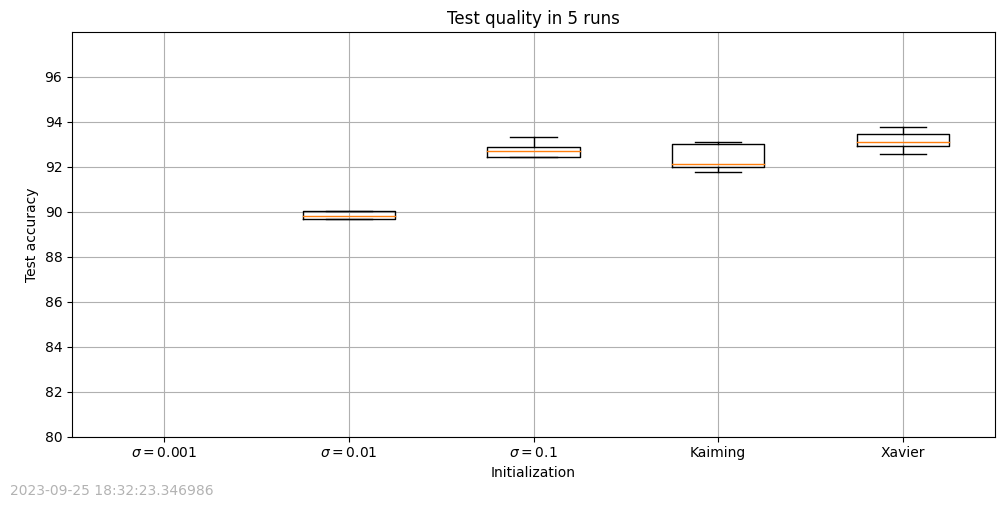

In [ ]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

### 5层

在此执行与上一段相同的代码，但仅使用网络中的 $5$ 层。

### 5 layers

Execute here the same code as in the previous paragraph, but only with $5$ layers in the network.

In [ ]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [ ]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [ ]:
accs_train, accs_test = machine_v2(5, 5, 5)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.237/2.254. Accuracy, % (Train/Test): 16.48/12.98
Loss (Train/Test): 1.690/1.721. Accuracy, % (Train/Test): 30.07/29.60
Loss (Train/Test): 1.033/1.197. Accuracy, % (Train/Test): 63.47/60.09
Loss (Train/Test): 0.493/0.848. Accuracy, % (Train/Test): 82.41/78.49
Loss (Train/Test): 0.133/0.885. Accuracy, % (Train/Test): 95.10/85.39
Loss (Train/Test): 0.034/1.803. Accuracy, % (Train/Test): 98.44/86.05
Loss (Train/Test): 0.004/2.650. Accuracy, % (Train/Test): 100.00/86.50
Loss (Train/Test): 0.000/6.017. Accuracy, % (Train/Test): 100.00/86.20
Loss (Train/Test): 0.000/14.978. Accuracy, % (Train/Test): 100.00/85.24


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 58.448/58.727. Accuracy, % (Train/Test): 10.02/9.94
Loss (Train/Test): 1.552/1.611. Accuracy, % (Train/Test): 40.09/40.65
Loss (Train/Test): 1.045/1.227. Accuracy, % (Train/Test): 59.02/55.27
Loss (Train/Test): 0.504/0.818. Accuracy, % (Train/Test): 81.51/75.45
Loss (Train/Test): 0.258/0.906. Accuracy, % (Train/Test): 90.87/83.46
Loss (Train/Test): 0.508/1.927. Accuracy, % (Train/Test): 86.86/76.48
Loss (Train/Test): 0.071/1.254. Accuracy, % (Train/Test): 98.22/87.91
Loss (Train/Test): 0.015/2.707. Accuracy, % (Train/Test): 99.78/88.50
Loss (Train/Test): 0.005/4.215. Accuracy, % (Train/Test): 100.00/88.72


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 4.807/4.846. Accuracy, % (Train/Test): 10.02/9.79
Loss (Train/Test): 1.516/1.545. Accuracy, % (Train/Test): 36.30/35.53
Loss (Train/Test): 1.066/1.194. Accuracy, % (Train/Test): 63.70/59.05
Loss (Train/Test): 0.411/0.775. Accuracy, % (Train/Test): 83.74/76.04
Loss (Train/Test): 0.130/1.077. Accuracy, % (Train/Test): 96.44/81.82
Loss (Train/Test): 0.032/3.444. Accuracy, % (Train/Test): 99.33/83.46
Loss (Train/Test): 0.005/5.748. Accuracy, % (Train/Test): 99.78/83.98
Loss (Train/Test): 0.000/20.482. Accuracy, % (Train/Test): 100.00/84.05
Loss (Train/Test): 0.000/32.147. Accuracy, % (Train/Test): 100.00/84.05


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.275/2.289. Accuracy, % (Train/Test): 11.36/10.53
Loss (Train/Test): 2.807/2.792. Accuracy, % (Train/Test): 34.97/34.72
Loss (Train/Test): 0.692/0.897. Accuracy, % (Train/Test): 72.83/68.55
Loss (Train/Test): 0.382/0.807. Accuracy, % (Train/Test): 85.30/77.89
Loss (Train/Test): 0.166/1.086. Accuracy, % (Train/Test): 94.21/83.61
Loss (Train/Test): 0.049/1.711. Accuracy, % (Train/Test): 98.44/84.64
Loss (Train/Test): 0.004/5.362. Accuracy, % (Train/Test): 100.00/84.94
Loss (Train/Test): 0.000/28.472. Accuracy, % (Train/Test): 100.00/85.46
Loss (Train/Test): 0.000/36.600. Accuracy, % (Train/Test): 100.00/85.53


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.960/1.991. Accuracy, % (Train/Test): 25.17/22.70
Loss (Train/Test): 1.462/1.606. Accuracy, % (Train/Test): 41.87/36.42
Loss (Train/Test): 0.969/1.518. Accuracy, % (Train/Test): 61.92/60.16
Loss (Train/Test): 0.427/0.990. Accuracy, % (Train/Test): 86.19/80.71
Loss (Train/Test): 0.141/1.600. Accuracy, % (Train/Test): 93.99/86.72
Loss (Train/Test): 0.002/5.216. Accuracy, % (Train/Test): 100.00/87.31
Loss (Train/Test): 0.000/16.342. Accuracy, % (Train/Test): 100.00/86.65
Loss (Train/Test): 0.000/22.921. Accuracy, % (Train/Test): 100.00/86.87
Loss (Train/Test): 0.000/22.921. Accuracy, % (Train/Test): 100.00/86.87


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.310/2.307. Accuracy, % (Train/Test): 9.80/9.50
Loss (Train/Test): 0.699/0.769. Accuracy, % (Train/Test): 77.28/75.07
Loss (Train/Test): 0.212/0.508. Accuracy, % (Train/Test): 91.76/88.58
Loss (Train/Test): 0.022/1.085. Accuracy, % (Train/Test): 99.33/90.21
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/7.256. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/7.256. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/7.256. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/7.256. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/7.256. Accuracy, % (Train/Test): 100.00/89.99


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.294/2.307. Accuracy, % (Train/Test): 12.47/9.35
Loss (Train/Test): 0.622/0.790. Accuracy, % (Train/Test): 78.84/75.45
Loss (Train/Test): 0.053/0.507. Accuracy, % (Train/Test): 98.89/91.10
Loss (Train/Test): 0.000/1.864. Accuracy, % (Train/Test): 100.00/92.36
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/2.756. Accuracy, % (Train/Test): 100.00/91.77


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.303/2.301. Accuracy, % (Train/Test): 9.13/8.83
Loss (Train/Test): 0.583/0.755. Accuracy, % (Train/Test): 77.28/76.71
Loss (Train/Test): 0.064/0.818. Accuracy, % (Train/Test): 98.00/88.35
Loss (Train/Test): 0.000/3.013. Accuracy, % (Train/Test): 100.00/89.47
Loss (Train/Test): 0.000/6.241. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/6.241. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/6.241. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/6.241. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/6.241. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/6.241. Accuracy, % (Train/Test): 100.00/89.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.311/2.305. Accuracy, % (Train/Test): 8.24/7.42
Loss (Train/Test): 0.324/0.523. Accuracy, % (Train/Test): 90.65/86.72
Loss (Train/Test): 0.007/0.923. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/4.663. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/5.096. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/5.096. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/5.096. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/5.096. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/5.096. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/5.096. Accuracy, % (Train/Test): 100.00/90.80


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.293/2.291. Accuracy, % (Train/Test): 8.02/9.42
Loss (Train/Test): 0.923/1.035. Accuracy, % (Train/Test): 68.60/63.95
Loss (Train/Test): 0.267/0.752. Accuracy, % (Train/Test): 90.20/84.35
Loss (Train/Test): 0.063/1.299. Accuracy, % (Train/Test): 98.44/86.28
Loss (Train/Test): 0.002/3.543. Accuracy, % (Train/Test): 100.00/87.91
Loss (Train/Test): 0.000/11.084. Accuracy, % (Train/Test): 100.00/87.46
Loss (Train/Test): 0.000/13.734. Accuracy, % (Train/Test): 100.00/87.31
Loss (Train/Test): 0.000/13.734. Accuracy, % (Train/Test): 100.00/87.31
Loss (Train/Test): 0.000/13.734. Accuracy, % (Train/Test): 100.00/87.31
Loss (Train/Test): 0.000/13.734. Accuracy, % (Train/Test): 100.00/87.31


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 22.421/22.372. Accuracy, % (Train/Test): 6.90/5.86
Loss (Train/Test): 0.235/0.730. Accuracy, % (Train/Test): 91.31/78.71
Loss (Train/Test): 0.001/0.909. Accuracy, % (Train/Test): 100.00/89.54
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/1.803. Accuracy, % (Train/Test): 100.00/90.28


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 27.673/28.496. Accuracy, % (Train/Test): 9.13/7.79
Loss (Train/Test): 0.624/0.907. Accuracy, % (Train/Test): 79.51/73.22
Loss (Train/Test): 0.016/0.707. Accuracy, % (Train/Test): 99.78/88.50
Loss (Train/Test): 0.000/1.566. Accuracy, % (Train/Test): 100.00/91.25
Loss (Train/Test): 0.000/1.982. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/1.982. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/1.982. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/1.982. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/1.982. Accuracy, % (Train/Test): 100.00/91.69
Loss (Train/Test): 0.000/1.982. Accuracy, % (Train/Test): 100.00/91.69


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 13.954/13.470. Accuracy, % (Train/Test): 19.15/19.96
Loss (Train/Test): 0.179/0.678. Accuracy, % (Train/Test): 95.10/83.23
Loss (Train/Test): 0.000/1.021. Accuracy, % (Train/Test): 100.00/89.61
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32
Loss (Train/Test): 0.000/2.188. Accuracy, % (Train/Test): 100.00/91.32


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 22.330/23.396. Accuracy, % (Train/Test): 10.02/8.75
Loss (Train/Test): 0.642/1.000. Accuracy, % (Train/Test): 78.40/70.77
Loss (Train/Test): 0.028/0.630. Accuracy, % (Train/Test): 99.78/87.31
Loss (Train/Test): 0.000/1.276. Accuracy, % (Train/Test): 100.00/90.80
Loss (Train/Test): 0.000/1.869. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/1.869. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/1.869. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/1.869. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/1.869. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/1.869. Accuracy, % (Train/Test): 100.00/91.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 31.980/33.327. Accuracy, % (Train/Test): 2.67/2.23
Loss (Train/Test): 0.193/0.686. Accuracy, % (Train/Test): 92.87/83.61
Loss (Train/Test): 0.001/0.627. Accuracy, % (Train/Test): 100.00/90.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.106. Accuracy, % (Train/Test): 100.00/92.43


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 3.493/3.572. Accuracy, % (Train/Test): 17.59/15.36
Loss (Train/Test): 0.205/0.420. Accuracy, % (Train/Test): 92.20/88.35
Loss (Train/Test): 0.000/0.957. Accuracy, % (Train/Test): 100.00/91.10
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95
Loss (Train/Test): 0.000/2.266. Accuracy, % (Train/Test): 100.00/90.95


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 5.418/5.433. Accuracy, % (Train/Test): 9.58/9.94
Loss (Train/Test): 0.156/0.335. Accuracy, % (Train/Test): 95.99/89.69
Loss (Train/Test): 0.000/0.858. Accuracy, % (Train/Test): 100.00/92.43
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95
Loss (Train/Test): 0.000/1.958. Accuracy, % (Train/Test): 100.00/92.95


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.920/2.964. Accuracy, % (Train/Test): 6.46/7.57
Loss (Train/Test): 0.333/0.509. Accuracy, % (Train/Test): 88.64/84.05
Loss (Train/Test): 0.026/0.557. Accuracy, % (Train/Test): 98.89/90.36
Loss (Train/Test): 0.000/1.578. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/2.748. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/2.748. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/2.748. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/2.748. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/2.748. Accuracy, % (Train/Test): 100.00/91.84
Loss (Train/Test): 0.000/2.748. Accuracy, % (Train/Test): 100.00/91.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.561/2.607. Accuracy, % (Train/Test): 8.46/5.34
Loss (Train/Test): 0.415/0.600. Accuracy, % (Train/Test): 84.63/80.64
Loss (Train/Test): 0.001/1.095. Accuracy, % (Train/Test): 100.00/89.39
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28
Loss (Train/Test): 0.000/2.909. Accuracy, % (Train/Test): 100.00/90.28


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.550/2.512. Accuracy, % (Train/Test): 9.35/10.31
Loss (Train/Test): 0.229/0.428. Accuracy, % (Train/Test): 93.10/87.02
Loss (Train/Test): 0.002/0.629. Accuracy, % (Train/Test): 100.00/92.36
Loss (Train/Test): 0.000/1.930. Accuracy, % (Train/Test): 100.00/92.66
Loss (Train/Test): 0.000/2.123. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/2.123. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/2.123. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/2.123. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/2.123. Accuracy, % (Train/Test): 100.00/92.73
Loss (Train/Test): 0.000/2.123. Accuracy, % (Train/Test): 100.00/92.73


让我们构建所获得的质量的箱线图（每列中的水平线是平均值，矩形显示分布）。

Let's build boxplots of the obtained quality (the horizontal line in each column is the average, the rectangle shows the spread).

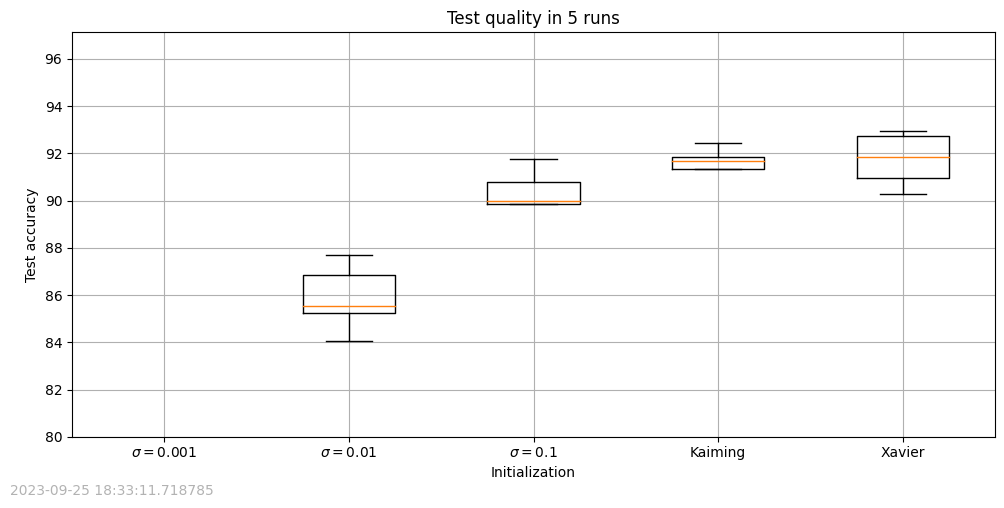

In [ ]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_ylim(80)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

* 不同初始化期间学习过程的质量和稳定性有何不同？
* 哪些初始化有助于训练更深的网络？

__答案：__

1) 当使用正态分布、最小方差、4 个或更多级别进行初始化时，模型未经过训练。 具有初始化 Xavier 和 Kaiming 的模型表现最佳。

2）通过 Kaimng 和 Xavier 初始化可以更好地训练具有大量级别的网络。

* How do the quality and stability of the learning process differ during different initializations?
* Which initializations help train deeper networks?

__Answers:__

1) When initialized with a normal distribution, with the smallest variance, with 4 levels or more, the model is not trained. Models with initialization Xavier and Kaiming behave best.

2) Networks with a large number of levels are trained better with Kaimng and Xavier initialization.

现在让我们比较不同初始化的学习率。 创建两个列表`accs_test_on_iterations`，`accs_train_on_iterations`，每个列表中的位置`[i]`（参见上一段中`i`的描述）将有一个测试上的`accuracy`值列表和训练样本，分别是模型训练时获得的。 将网络层数设置为 4。

Now let's compare the learning rate for different initializations. Create two lists of lists `accs_test_on_iterations`, `accs_train_on_iterations` in each of which in position `[i]` (see description of `i` in the previous paragraph) there will be a list of `accuracy` values on the test and training samples, respectively, obtained in model training time. Set the number of layers in the network to 4.

In [ ]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [ ]:
accs_test_on_iterations = []
accs_train_on_iterations = []


def machine_v3(k, accs_test_on_iterations, accs_train_on_iterations):
    for ind in range(k):
          dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size,
            n_classes=n_classes, n_layers=4, activation=ReLU)

          dense_network.to(device).float()
          initialize_module(dense_network, init_vars[ind])


          opter = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
          loss_fn = CrossEntropyLoss()

          results = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn,
            optimizer = opter, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device)
          accs_test_on_iterations += [results[2]]
          accs_train_on_iterations += [results[3]]
    return accs_test_on_iterations, accs_train_on_iterations

accs_test_on_iterations, accs_train_on_iterations = machine_v3(5, [], [])

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 3.831/3.937. Accuracy, % (Train/Test): 17.82/18.55
Loss (Train/Test): 0.899/0.997. Accuracy, % (Train/Test): 69.71/63.58
Loss (Train/Test): 0.198/0.473. Accuracy, % (Train/Test): 93.10/87.46
Loss (Train/Test): 0.023/1.351. Accuracy, % (Train/Test): 99.55/86.20
Loss (Train/Test): 0.000/7.479. Accuracy, % (Train/Test): 100.00/86.94
Loss (Train/Test): 0.000/15.481. Accuracy, % (Train/Test): 100.00/87.24
Loss (Train/Test): 0.000/15.481. Accuracy, % (Train/Test): 100.00/87.24
Loss (Train/Test): 0.000/15.481. Accuracy, % (Train/Test): 100.00/87.24
Loss (Train/Test): 0.000/15.481. Accuracy, % (Train/Test): 100.00/87.24


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.952/1.984. Accuracy, % (Train/Test): 26.73/24.33
Loss (Train/Test): 0.862/0.960. Accuracy, % (Train/Test): 70.16/68.47
Loss (Train/Test): 0.193/0.473. Accuracy, % (Train/Test): 92.43/87.17
Loss (Train/Test): 0.001/1.799. Accuracy, % (Train/Test): 100.00/90.21
Loss (Train/Test): 0.000/5.315. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/5.315. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/5.315. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/5.315. Accuracy, % (Train/Test): 100.00/89.99
Loss (Train/Test): 0.000/5.315. Accuracy, % (Train/Test): 100.00/89.99


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.323/2.305. Accuracy, % (Train/Test): 9.13/9.72
Loss (Train/Test): 0.200/0.473. Accuracy, % (Train/Test): 92.43/86.28
Loss (Train/Test): 0.000/1.860. Accuracy, % (Train/Test): 100.00/92.28
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06
Loss (Train/Test): 0.000/3.099. Accuracy, % (Train/Test): 100.00/92.06


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 33.598/32.450. Accuracy, % (Train/Test): 8.02/8.01
Loss (Train/Test): 0.172/0.467. Accuracy, % (Train/Test): 94.65/86.65
Loss (Train/Test): 0.000/0.611. Accuracy, % (Train/Test): 100.00/93.03
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84
Loss (Train/Test): 0.000/0.969. Accuracy, % (Train/Test): 100.00/93.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 7.452/7.161. Accuracy, % (Train/Test): 8.02/9.20
Loss (Train/Test): 0.046/0.318. Accuracy, % (Train/Test): 99.11/92.80
Loss (Train/Test): 0.000/0.859. Accuracy, % (Train/Test): 100.00/94.51
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58
Loss (Train/Test): 0.000/1.109. Accuracy, % (Train/Test): 100.00/94.58


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars_for_plot):
    ax.plot(accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

* 学习率如何根据所选的初始化而变化？

__答案：__

Xavier 方法表现出最佳性能。 Kaiming 方法和方差为 0.1 的正态分布显示出相似的结果。 最差的行为是方差为 0.01 和 0.001。

* How does the learning rate change depending on the initialization chosen?

__Answers:__

The Xavier method showed the best behavior. Kaiming methods and normal distribution with variance 0.1 showed similar results. The worst behavior is with variance 0.01 and 0.001.

## 使用不同的激活函数进行实验。

## Experiments with different activation functions.

现在让我们检查一下神经网络使用哪种激活函数可以学得更好。

此时，可以尝试训练具有不同激活函数的多个神经网络。

为此，我们需要实现另一个 $2$ 层：用于激活函数“Tanh”和“Sigmoid”。

Let us now check with which activation function the neural network will learn better.

At this point, you can try training multiple neural networks with different activation functions.

To do this, we need to implement another $2$ layers: for the activation functions `Tanh` and `Sigmoid`.

In [ ]:
class Tanh(torch.nn.Module):
    def __init__(self):
        """
        tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
        Используйте функцию torch.tanh для подсчета гиперболического тангенса.
        Вы можете сами реализовать подсчет tanh, но тогда вам нужно устойчиво его вычислять.
        """
        super().__init__()

        self.activation = torch.tanh

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Поэлементное применение Tanh
        """

        return self.activation(x)

    def __repr__(self):
        return 'Tanh()'

In [ ]:
class Sigmoid(torch.nn.Module):
    def __init__(self):
        """
        sigmoid(y) = 1 / (1 + e^(-y))
        Используйте функцию torch.special.expit для подсчета сигмоиды.
        Вы можете сами реализовать подсчет сигмоиды, но тогда вам нужно устойчиво ее вычислять.
        """
        super().__init__()

        self.activation = torch.special.expit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Поэлементное применение Sigmoid
        """

        return self.activation(x)

    def __repr__(self):
        return 'Sigmoid()'

现在尝试对 3 个激活函数中的每一个激活神经网​​络进行多次训练。 将层数固定为 $3$。 在“Tanh”和“Sigmoid”的情况下，使用“Xavier”初始化，在“ReLU”的情况下，使用“Kaiming”初始化。

Now try training the neural network several times for each of the 3 activation functions. Fix the number of layers equal to $3$. In the case of `Tanh` and `Sigmoid` use the `Xavier` initialization, and in the case of `ReLU` use the `Kaiming` initialization.

填写“accs_train”和“accs_test”矩阵。 位置“[i, j]”应包含网络在第 $j$ 次运行时正确答案的份额值（所有运行都相同），激活函数 $ReLU$ 对于 $i = 0$，其中$i = 1$ 的激活函数 $Tanh$ 以及 $i = 2$ 的激活函数 $Sigmoid$。

Fill in the `accs_train` and `accs_test` matrices. Position `[i, j]` should contain the value of the share of correct answers of the network at the $j$-th run (all runs are identical) with the activation function $ReLU$ for $i = 0$, with the activation function $Tanh$ for $i = 1$ and with the activation function $Sigmoid$ for $i = 2$.


In [ ]:
act_func_vars = ['Tanh', 'Sigmoid', 'ReLU']
init_for_act_funcs = ['Xavier', 'Xavier', 'Kaiming']

In [ ]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [ ]:
def machine_v4(k, l):
    for ind in range(k):
      for jdn in range(l):
          dense_network = DenseNetwork(
            in_features=in_features, hidden_size=hidden_size,
            n_classes=n_classes, n_layers=5, activation=globals()[act_func_vars[ind]])

          dense_network.to(device).float()
          initialize_module(dense_network, init_vars[ind])


          opter = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)
          loss_fn = CrossEntropyLoss()

          results = training_loop(
            n_epochs=200, network=dense_network, loss_fn=loss_fn,
            optimizer = opter, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device)
          accs_train[ind, jdn] = results[2][-1]
          accs_test[ind, jdn] = results[3][-1]
    return accs_train, accs_test

accs_train, accs_test = machine_v4(3, 5)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 243.522/257.326. Accuracy, % (Train/Test): 27.62/26.56
Loss (Train/Test): 22345.736/24390.490. Accuracy, % (Train/Test): 32.29/28.93
Loss (Train/Test): 49439036.000/50367180.000. Accuracy, % (Train/Test): 16.48/15.43
Loss (Train/Test): 469242208.000/476280192.000. Accuracy, % (Train/Test): 8.02/10.24
Loss (Train/Test): 1316741248.000/1342968832.000. Accuracy, % (Train/Test): 21.83/20.40
Loss (Train/Test): 94619040063946752.000/96500158430183424.000. Accuracy, % (Train/Test): 12.69/13.58
Loss (Train/Test): 59088984163473928354791424.000/60572623507520258599550976.000. Accuracy, % (Train/Test): 17.59/21.22
Loss (Train/Test): 14958365576063102728516686315520.000/14588054672553667207495738720256.000. Accuracy, % (Train/Test): 19.15/19.07
Loss (Train/Test): nan/nan. Accuracy, % (Train/Test): 9.35/10.09


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.773/1.884. Accuracy, % (Train/Test): 40.98/38.43
Loss (Train/Test): 0.181/1.058. Accuracy, % (Train/Test): 93.76/78.78
Loss (Train/Test): 0.053/1.177. Accuracy, % (Train/Test): 97.77/81.82
Loss (Train/Test): 0.029/1.617. Accuracy, % (Train/Test): 99.78/81.53
Loss (Train/Test): 0.013/2.239. Accuracy, % (Train/Test): 99.78/81.38
Loss (Train/Test): 381219.844/379757.844. Accuracy, % (Train/Test): 9.13/9.72
Loss (Train/Test): 34730632.000/34844392.000. Accuracy, % (Train/Test): 8.46/11.42
Loss (Train/Test): 14895325.000/15182499.000. Accuracy, % (Train/Test): 28.73/26.71
Loss (Train/Test): 11948975.000/12218351.000. Accuracy, % (Train/Test): 20.49/19.29


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.589/3.070. Accuracy, % (Train/Test): 44.77/39.76
Loss (Train/Test): 0.214/0.673. Accuracy, % (Train/Test): 94.43/82.12
Loss (Train/Test): 0.032/1.028. Accuracy, % (Train/Test): 99.55/85.46
Loss (Train/Test): 0.002/1.839. Accuracy, % (Train/Test): 100.00/84.12
Loss (Train/Test): 16.596/26.264. Accuracy, % (Train/Test): 76.17/67.58
Loss (Train/Test): 4634.008/4921.800. Accuracy, % (Train/Test): 6.46/6.38
Loss (Train/Test): 96750.312/99154.312. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 434394816.000/442037792.000. Accuracy, % (Train/Test): 12.25/9.64
Loss (Train/Test): 188681296.000/178731536.000. Accuracy, % (Train/Test): 9.80/10.24


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 1.842/1.913. Accuracy, % (Train/Test): 26.95/21.66
Loss (Train/Test): 0.641/0.955. Accuracy, % (Train/Test): 74.16/69.51
Loss (Train/Test): 0.149/0.788. Accuracy, % (Train/Test): 95.77/83.61
Loss (Train/Test): 0.043/1.143. Accuracy, % (Train/Test): 98.89/84.64
Loss (Train/Test): 0.323/3.020. Accuracy, % (Train/Test): 93.10/82.57
Loss (Train/Test): 24.527/29.583. Accuracy, % (Train/Test): 51.89/52.30
Loss (Train/Test): 494709.188/490342.219. Accuracy, % (Train/Test): 9.35/10.16
Loss (Train/Test): 956125568.000/1004741632.000. Accuracy, % (Train/Test): 19.60/17.58
Loss (Train/Test): 146238112.000/140308608.000. Accuracy, % (Train/Test): 10.47/10.68


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.298/2.306. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.299/2.306. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.298/2.308. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.298/2.306. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.298/2.307. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42
Loss (Train/Test): 2.297/2.311. Accuracy, % (Train/Test): 12.25/9.42


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.300. Accuracy, % (Train/Test): 8.69/10.61
Loss (Train/Test): 0.801/1.054. Accuracy, % (Train/Test): 70.60/65.36
Loss (Train/Test): 0.087/0.592. Accuracy, % (Train/Test): 96.88/89.61
Loss (Train/Test): 0.000/4.009. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/7.754. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/7.754. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/7.754. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/7.754. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/7.754. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/7.754. Accuracy, % (Train/Test): 100.00/89.84


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.285/2.281. Accuracy, % (Train/Test): 13.59/14.76
Loss (Train/Test): 0.695/0.925. Accuracy, % (Train/Test): 77.95/74.04
Loss (Train/Test): 0.184/0.642. Accuracy, % (Train/Test): 93.32/87.61
Loss (Train/Test): 0.020/1.862. Accuracy, % (Train/Test): 99.55/89.61
Loss (Train/Test): 0.000/6.450. Accuracy, % (Train/Test): 100.00/89.84
Loss (Train/Test): 0.000/10.830. Accuracy, % (Train/Test): 100.00/89.54
Loss (Train/Test): 0.000/10.830. Accuracy, % (Train/Test): 100.00/89.54
Loss (Train/Test): 0.000/10.830. Accuracy, % (Train/Test): 100.00/89.54
Loss (Train/Test): 0.000/10.830. Accuracy, % (Train/Test): 100.00/89.54
Loss (Train/Test): 0.000/10.830. Accuracy, % (Train/Test): 100.00/89.54


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.279/2.277. Accuracy, % (Train/Test): 13.81/16.47
Loss (Train/Test): 2.008/2.092. Accuracy, % (Train/Test): 39.42/40.50
Loss (Train/Test): 0.454/0.593. Accuracy, % (Train/Test): 83.96/82.20
Loss (Train/Test): 0.101/0.687. Accuracy, % (Train/Test): 97.33/88.87
Loss (Train/Test): 0.002/1.631. Accuracy, % (Train/Test): 100.00/89.91
Loss (Train/Test): 0.000/5.228. Accuracy, % (Train/Test): 100.00/89.24
Loss (Train/Test): 0.000/6.251. Accuracy, % (Train/Test): 100.00/89.32
Loss (Train/Test): 0.000/6.251. Accuracy, % (Train/Test): 100.00/89.32
Loss (Train/Test): 0.000/6.251. Accuracy, % (Train/Test): 100.00/89.32
Loss (Train/Test): 0.000/6.251. Accuracy, % (Train/Test): 100.00/89.32


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.288/2.285. Accuracy, % (Train/Test): 9.80/10.98
Loss (Train/Test): 0.674/0.764. Accuracy, % (Train/Test): 74.39/74.85
Loss (Train/Test): 0.021/0.894. Accuracy, % (Train/Test): 99.78/91.99
Loss (Train/Test): 0.000/2.642. Accuracy, % (Train/Test): 100.00/91.47
Loss (Train/Test): 0.000/4.810. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/4.810. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/4.810. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/4.810. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/4.810. Accuracy, % (Train/Test): 100.00/91.77
Loss (Train/Test): 0.000/4.810. Accuracy, % (Train/Test): 100.00/91.77


  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.307/2.298. Accuracy, % (Train/Test): 13.36/14.84
Loss (Train/Test): 0.709/0.784. Accuracy, % (Train/Test): 76.39/75.89
Loss (Train/Test): 0.093/0.363. Accuracy, % (Train/Test): 97.10/91.84
Loss (Train/Test): 0.005/1.133. Accuracy, % (Train/Test): 99.78/91.84
Loss (Train/Test): 0.000/3.764. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/5.377. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/5.377. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/5.377. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/5.377. Accuracy, % (Train/Test): 100.00/90.50
Loss (Train/Test): 0.000/5.377. Accuracy, % (Train/Test): 100.00/90.50


让我们构建所获得的质量的箱线图（每列中的水平线是平均值，矩形显示分布）。

Let's build boxplots of the obtained quality (the horizontal line in each column is the average, the rectangle shows the spread).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=act_func_vars, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Activation function")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.text(
    0.0, 0.0, str(datetime.now()),
    fontsize=10, color='gray', alpha=0.6,
)

fig.tight_layout()
plt.show()

* 对于不同的激活函数，学习过程的质量控制和稳定性有何不同？

__答案：__


通过 ReLU 激活获得更好的质量和稳定性。 Segmoid 最差，Tanh 好一点。

* How do quality control and stability of the learning process differ for different activation functions?

__Answers:__


Better quality and stability with ReLU activation. Segmoid is the worst, Tanh is a little better.